In [1]:
import os

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

os.environ["OMP_NUM_THREADS"] = '8'
#import jax
#jax.config.update("jax_debug_nans", True)
import numpyro
numpyro.set_host_device_count(8)
import sys

sys.path.append('/Users/tomohiroyoshida/frappe/frappe/')
import frappe

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

# デバイス情報を詳細表示
print(f"Local device count: {jax.local_device_count()}")
print(f"Process count: {jax.process_count()}")
for i, device in enumerate(jax.devices()):
    print(f"Device {i}: {device}")
    
    

Local device count: 8
Process count: 1
Device 0: TFRT_CPU_0
Device 1: TFRT_CPU_1
Device 2: TFRT_CPU_2
Device 3: TFRT_CPU_3
Device 4: TFRT_CPU_4
Device 5: TFRT_CPU_5
Device 6: TFRT_CPU_6
Device 7: TFRT_CPU_7


In [3]:
import pickle

import glob

loaded_data = {}

obs_ebs = glob.glob('./HD*.pkl')[::-1]


In [4]:
loaded_data = {}

data_ids = []

_id = 0

for obs_eb in obs_ebs:
    
    data_id = f'data_id_{_id}'
    
    with open(obs_eb, "rb") as f:
        loaded_data[ data_id ] = pickle.load(f)
    data_ids.append( data_id )
    
    _id += 1

In [5]:
obs_ebs

['./HD169142_band3.pkl', './HD169142_band6.pkl', './HD169142_band9.pkl']

In [6]:
import jax.numpy as jnp
from jax.scipy.interpolate import RegularGridInterpolator
import numpy as np
import astropy.constants as cst
import dsharp_opac as opacity
from scipy.interpolate import CubicSpline

from scipy.ndimage import gaussian_filter1d


# 定数
c = cst.c.cgs.value

# データ読み込み
d = np.load('default_opacities_smooth_revised20251228.npz')
# d = np.load('dsharp_porus_opacities.npz')
# d = np.load('ricci_opacities.npz')


In [7]:
data_ids

['data_id_0', 'data_id_1', 'data_id_2']

In [8]:
obs_ebs

['./HD169142_band3.pkl', './HD169142_band6.pkl', './HD169142_band9.pkl']

In [9]:
s_f = { 'data_id_0': 0.01767, 'data_id_1':0.06286, 'data_id_2':0.2406 }
mean_f = { 'data_id_0': 1.0019, 'data_id_1':1.08809, 'data_id_2':1.61760 }

In [10]:
logP_res = np.array([])

lengthscales = np.arange( 0.01, 0.3, 0.01 )


def f_ff( V, obs, param ):
    
        nu = obs.nu
        name = obs.name
        
        nu0 = 100e9
        x = nu/nu0
        
        F_ff = 10**param['log10F0'] * x**(param['alpha_ff'])
    
        return V + F_ff / 1e3
    
    
D = 114.9
    
    
diskmodel = frappe.model( incl= 6.28,
                               r_out = 1.3,
                               N_GP = 130,
                               userdef_vis_model=f_ff,
                              jitter = 1e-6,
                              flux_uncert = True,
                              hyperparameters_fixed=True)
    
    
R = diskmodel.r_GP*D
    
gv = 1


lengthscale = 0.03


    
diskmodel.set_parameter('log10_Sigma_d', free = True,
                                    bounds = ( -6.0, 3.0 ), 
                                    #profile =  lambda x: np.log10(f_sigma( x*D )), 
                                    variance = gv, lengthscale = lengthscale)
    
Tmin = jnp.log10(77*(R/10)**(-0.5)/5)
Tmax = jnp.log10(77*(R/10)**(-0.5)*5)
    
    
    
diskmodel.set_parameter('log10_T', free = True,
                                    bounds = ( Tmin, Tmax ), 
                                    variance = gv, lengthscale = lengthscale)
    
diskmodel.set_parameter('log10_a_max', free = True, dust_prop = True,
                                    bounds =  ( -4.0, 2.0 ),
                                    variance = gv, lengthscale = lengthscale)
                           
                           
    
                           
    
diskmodel.set_parameter('q', free = True, dust_prop = True,
                                    bounds =  ( 1.0, 5.0 ), 
                                    variance = gv, lengthscale = lengthscale)
    
    
    
diskmodel.set_parameter('log10F0', free = True, dust_prop = False, GP = False,  mean_std =  ( -1, 1.0 ))
    
diskmodel.set_parameter('alpha_ff', free = True, dust_prop = False, GP = False,  mean_std = ( 0, 4 ))
    
    
     
    
    
    
for data_id in data_ids:
    diskmodel.set_observations( band = data_id,
                                            q = loaded_data[data_id]['q'],
                                            V = loaded_data[data_id]['V'] ,
                                            s = loaded_data[data_id]['s'] ,
                                            nu = loaded_data[data_id]['nu'],
                                            Nch = loaded_data[data_id]['Nch'],
                                            s_f = s_f[data_id],
                                            mean_fs = mean_f[data_id],
                                           )
        
        
    
    
diskmodel.set_opacity( opac_dict = d, Na = 400, Nq = 400, smooth = True, log10_a_smooth = 0.05, a_min=1e-5, a_max = 1e3 )



In [11]:
inference = frappe.inference( diskmodel )

In [12]:
prior = inference.prior(num_samples=100)

In [13]:
plotter = frappe.plot( prior )

saved keys:  dict_keys(['prior_f', 'prior_g'])


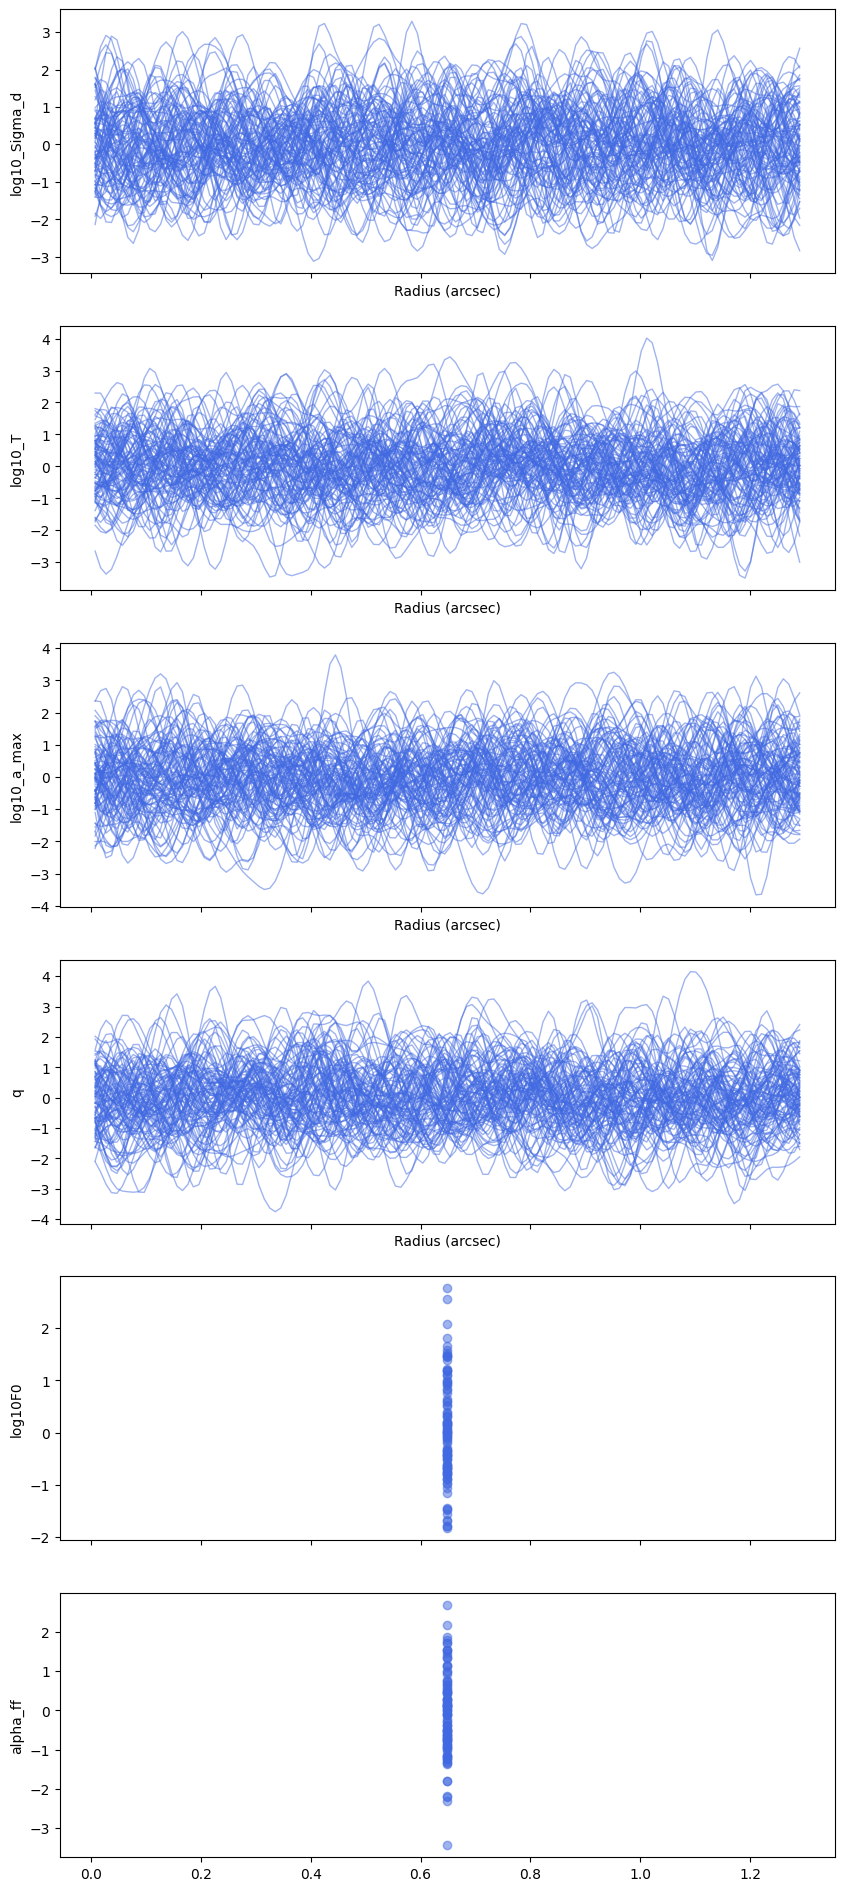

In [14]:
plotter.sample_paths( 'prior_g', nskip = 1 )

In [15]:
map_estimate = inference.SVI_MAP( num_iterations=10000, num_particles=1, adam_lr=0.01, uniform_radius = 0.1, seed = 1)

100%|█| 10000/10000 [00:03<00:00, 2750.38it/s, init loss: 4490444.0104, avg. los


In [16]:
map_estimate.sample['MAP_g']

{'V_final_data_id_0_ch_0': Array([[[ 1.34549957e-02,  1.24564145e-02,  1.10570957e-02,
           9.38533201e-03,  7.58623576e-03,  5.80423099e-03,
           4.16713746e-03,  2.77378250e-03,  1.68623827e-03,
           9.26998392e-04,  4.80818185e-04,  3.00554956e-04,
           3.16080589e-04,  4.45116869e-04,  6.04648320e-04,
           7.21460772e-04,  7.40436867e-04,  6.29577710e-04,
           3.81287608e-04,  1.01309413e-05, -4.52132199e-04,
          -9.63059845e-04, -1.47635868e-03, -1.94800491e-03,
          -2.34098637e-03, -2.62836936e-03, -2.79468502e-03,
          -2.83581254e-03, -2.75763804e-03, -2.57383438e-03,
          -2.30316397e-03, -1.96674206e-03, -1.58567649e-03,
          -1.17939444e-03, -7.64783575e-04, -3.56063800e-04,
           3.48658886e-05,  3.97934015e-04,  7.24543569e-04,
           1.00751780e-03,  1.24134784e-03,  1.42262200e-03,
           1.55045995e-03,  1.62678539e-03,  1.65632222e-03,
           1.64626251e-03,  1.60560915e-03,  1.54424137e-03

In [17]:
plotter = frappe.plot( map_estimate )

saved keys:  dict_keys(['MAP_g', 'MAP_f'])


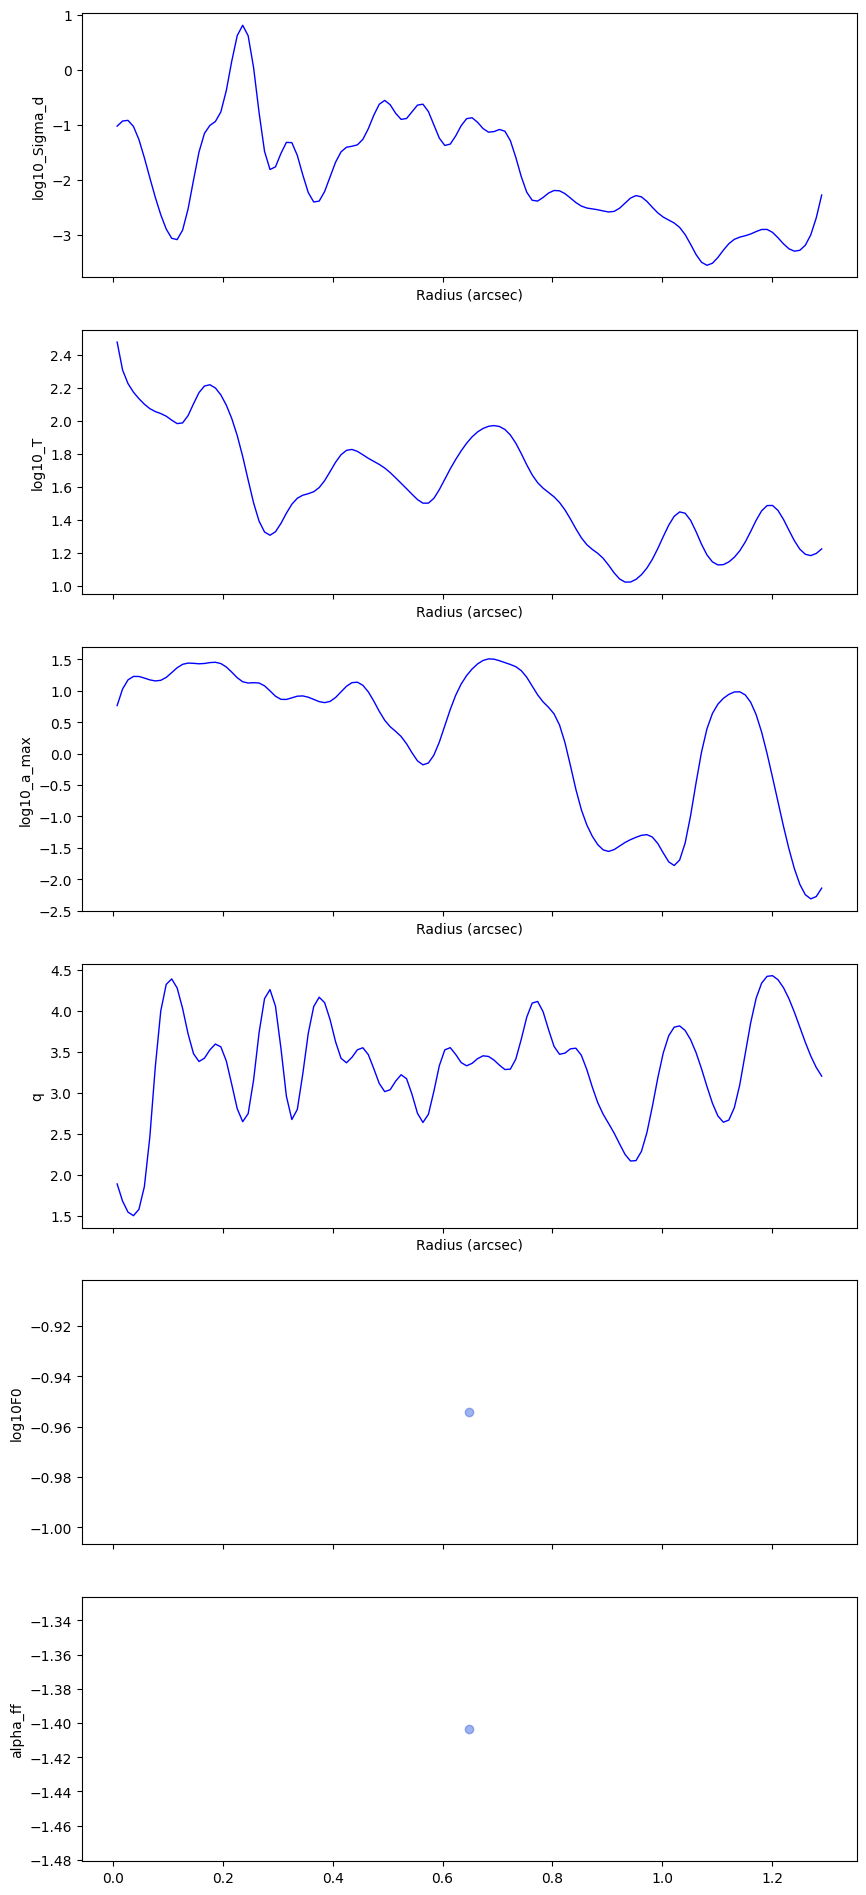

In [18]:
plotter.sample_paths( 'MAP_f', nskip = 1, plot_kwargs={'alpha':1, 'lw' : 1, 'color' : 'b'} )

In [15]:

num_warmup = 2000
num_samples = 1000




posterior = inference.MCMC( num_warmup = num_warmup, num_samples = num_samples,
                                   step_size = 1.0, num_chains = 8,
                                   max_tree_depth=10, uniform_radius = 0.2, seed = 1 )


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
            g_alpha_ff     -0.02      0.10     -0.04     -0.17      0.11      4.67      2.80
   g_f_scale_data_id_0     -0.51      1.11     -0.33     -2.04      1.85      4.39      4.07
   g_f_scale_data_id_1     -3.87      0.36     -3.91     -4.43     -3.31      5.18      2.69
   g_f_scale_data_id_2     -4.45      0.40     -4.60     -4.89     -3.60      4.22      5.51
             g_log10F0      0.05      0.03      0.06     -0.00      0.09      4.70      2.74
  g_log10_Sigma_d_z[0]     -0.76      1.11     -0.48     -3.23      0.61      4.08      8.28
  g_log10_Sigma_d_z[1]      0.47      1.04      0.22     -0.47      3.13      4.24      6.14
  g_log10_Sigma_d_z[2]     -0.29      0.63     -0.50     -1.13      0.79      4.77      3.44
  g_log10_Sigma_d_z[3]     -0.27      1.21     -0.50     -2.04      2.07      4.25      5.84
  g_log10_Sigma_d_z[4]     -0.49      1.01     -0.30     -1.95      1

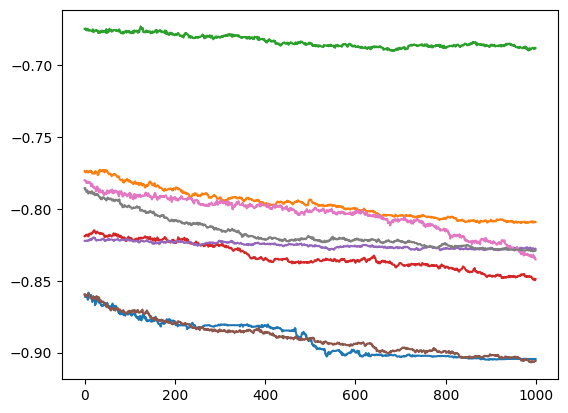

In [29]:
for i in range(8):
    plt.plot(posterior.sample['posterior_g']['lengthscale'][i])

(array([ 82., 378., 170., 178.,  49., 110.,  48.,  84.,  41., 158., 156.,
        171.,  85.,  33.,  63.,  58.,  37.,  26.,  24.,  36.,  13.,   0.,
          0.,   0.,   8.,  92.,  37.,  44.,  84., 140., 202.,  47.,  30.,
        402., 486., 493., 554., 170.,  70.,  73.,  49., 178., 202., 208.,
        148., 154., 228., 177., 192., 160., 103.,  76.,  40.,  54.,  22.,
         18.,  44.,  15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  12., 171., 348.,  70., 112., 105., 165.,
         17.]),
 array([-0.90682668, -0.90449242, -0.90215816, -0.8998239 , -0.89748964,
        -0.89515539, -0.89282113, -0.89048687, -0.88815261, -0.88581835,
        -0.88348409, -0.88114983, -0.87881557, -0.87648131, -0.87414705,
        -0.87181279, -0.86947853, -0.86714427, -0.86481001, -0.86247575,
        -0.8601415 , -0.85

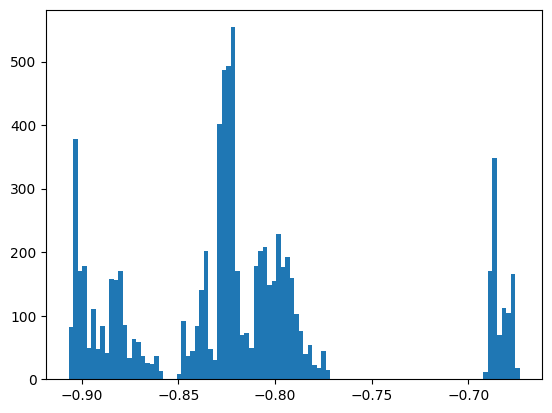

In [22]:
plt.hist(np.ravel(posterior.sample['posterior_g']['lengthscale']), bins=100)

In [23]:
plotter = frappe.plot( posterior )

saved keys:  dict_keys(['warmup_f', 'posterior_f', 'warmup_g', 'posterior_g'])


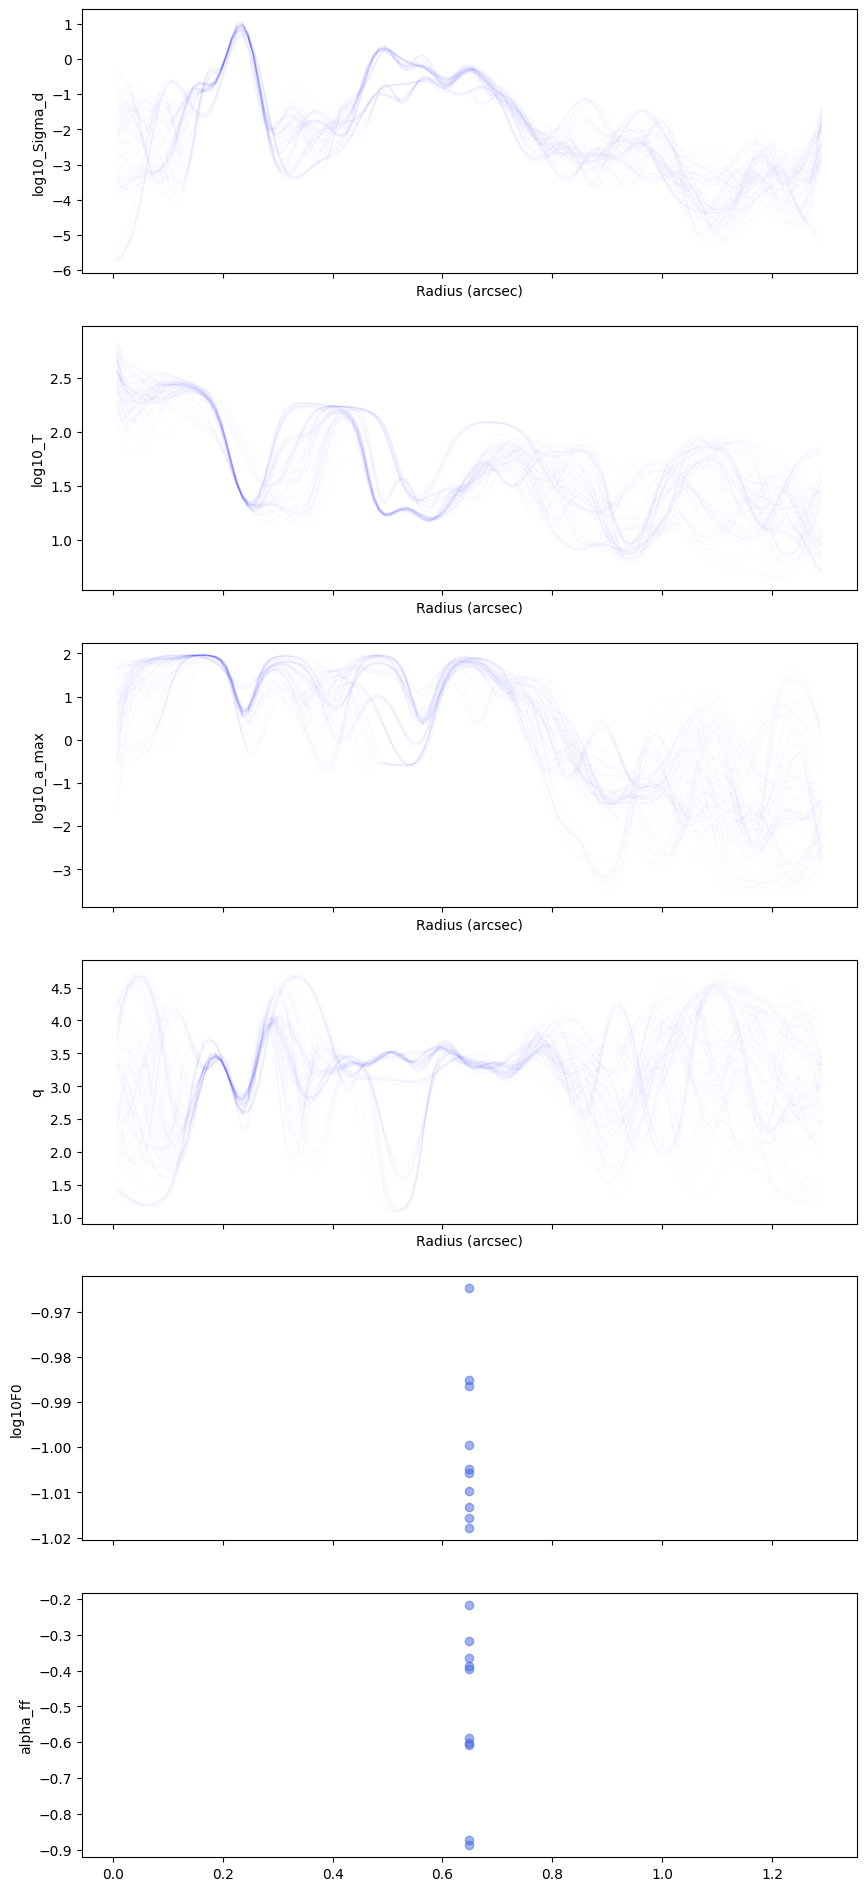

In [26]:
plotter.sample_paths( 'posterior_f', nskip = 100, plot_kwargs={'alpha':0.01, 'lw' : 1, 'color' : 'b'} )

In [21]:
slack_notify()

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110]
[0]
[0]
[0 1]
[0 1 2]
[0 1 2 3]
[0 1 2 3 4]
[0 1 2 3 4 5]
[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 1

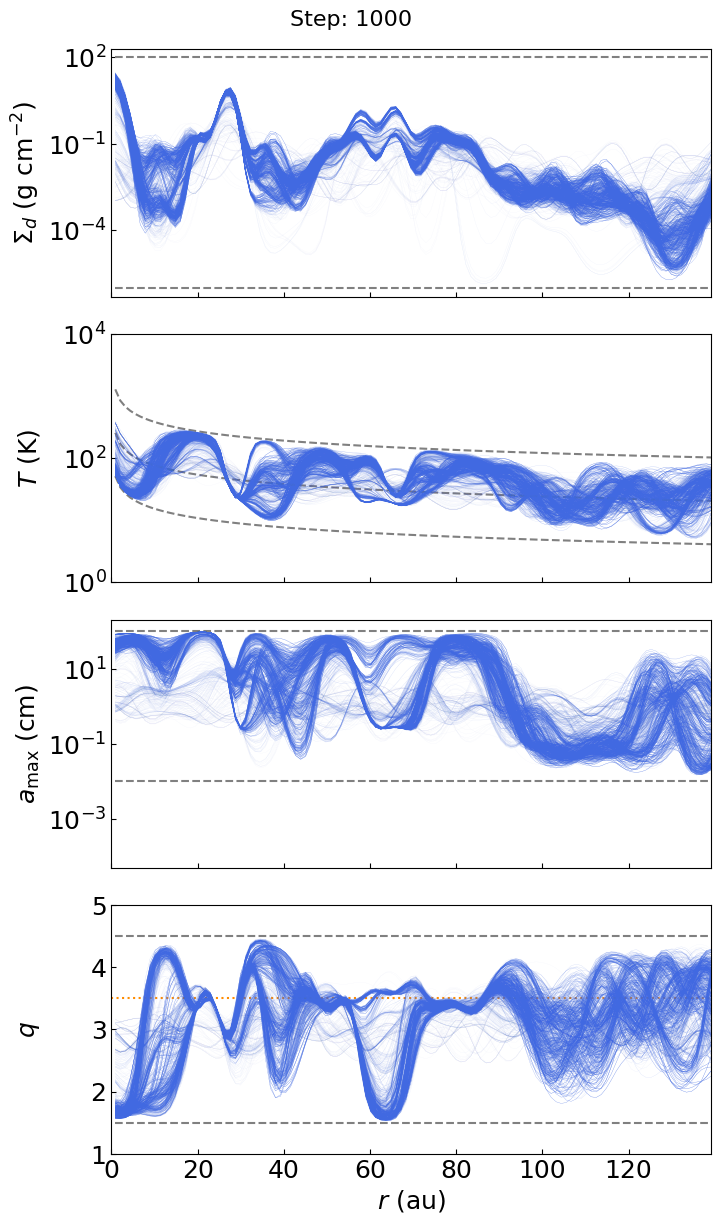

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams['font.size'] = 18
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

Nchain = 8
nstart = 0
Nsample = 1 + num_warmup + num_samples
nend = Nsample

nskip = int(Nsample/100)

window = 100

R = diskmodel.r_GP * D
Rmax = np.max(R)
Nr = len(R)


fig, axes = plt.subplots(4, 1, figsize=(8, 13),  sharex= True)
fig.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.10, hspace=0.15)
# Y軸ラベルを自動で揃える
fig.align_ylabels(axes)

p_idx = np.r_[0:nskip+1, nskip:Nsample:nskip]

p_sigma = np.reshape(mcmc_samples['Sigma_d'], (Nchain, Nsample, Nr))[:, p_idx, :]
p_T     = np.reshape(mcmc_samples['T'],       (Nchain, Nsample, Nr))[:, p_idx, :]
p_amax  = np.reshape(mcmc_samples['a_max'],   (Nchain, Nsample, Nr))[:, p_idx, :]
p_q     = np.reshape(mcmc_samples['q'],       (Nchain, Nsample, Nr))[:, p_idx, :]

Tmin = 10**np.log10(77*(R/10)**(-0.5)/5)
Tmid = 10**np.log10(77*(R/10)**(-0.5))
Tmax = 10**np.log10(77*(R/10)**(-0.5)*5)

steps = np.arange( np.shape(p_sigma)[1] )
print(steps)
#steps = steps_all

# 軸の初期設定
axes[0].set_yscale('log'); axes[0].set_xlim(0, Rmax); axes[0].set_ylim(0.5e-6, 1e2*2); axes[0].set_ylabel(r'$\Sigma_d\ {\rm (g\ cm^{-2})}$')
axes[1].set_yscale('log'); axes[1].set_xlim(0, Rmax); axes[1].set_ylim(1, 1e4);    axes[1].set_ylabel(r'$T\ {\rm (K)}$')
axes[2].set_yscale('log'); axes[2].set_xlim(0, Rmax); axes[2].set_ylim(0.5e-4, 2e2);  axes[2].set_ylabel(r'$a_{\rm max}\ {\rm (cm)}$')
axes[3].set_xlim(0, Rmax); axes[3].set_ylim(1, 5); axes[3].set_ylabel(r'$q$'); axes[3].set_xlabel(r'$r\ {\rm (au)}$')



axes[3].plot([0, Rmax], [3.5, 3.5], color='darkorange', ls=':' )

# priors
axes[0].plot(R, R*0 + 1e2, color='grey', ls='--' )
axes[0].plot(R, R*0 + 1e-6, color='grey', ls='--' )

axes[1].plot(R, Tmin, color='grey', ls='--' )
axes[1].plot(R, Tmid, color='grey', ls='--' )
axes[1].plot(R, Tmax, color='grey', ls='--' )

axes[2].plot(R, R*0 + 1e-2, color='grey', ls='--' )
axes[2].plot(R, R*0 + 1e2, color='grey', ls='--' )

axes[3].plot(R, R*0 + 1.5, color='grey', ls='--' )
axes[3].plot(R, R*0 + 4.5, color='grey', ls='--' )



# 最大本数 = Nchain × window
Nline = Nchain * window


alpha = 0.05
lines0 = [axes[0].plot(R, np.nan*R, lw=0.2, alpha=alpha, color='royalblue')[0] for _ in range(Nline)]
lines1 = [axes[1].plot(R, np.nan*R, lw=0.2, alpha=alpha, color='royalblue')[0] for _ in range(Nline)]
lines2 = [axes[2].plot(R, np.nan*R, lw=0.2, alpha=alpha, color='royalblue')[0] for _ in range(Nline)]
lines3 = [axes[3].plot(R, np.nan*R, lw=0.2, alpha=alpha, color='royalblue')[0] for _ in range(Nline)]

nan_array = np.full_like(R, np.nan)



def update(frame_id):

    jend = frame_id + 1
    jstart = np.max( [jend - window , 0] )
    
    
    jj_list = np.arange( jstart, jend, 1 )
    print(jj_list)

    idx = 0
    for i in range(Nchain):
        for jj in jj_list:

            
            lines0[idx].set_ydata(10**p_sigma[i, jj])
            lines1[idx].set_ydata(10**p_T[i, jj])
            lines2[idx].set_ydata(10**p_amax[i, jj])
            lines3[idx].set_ydata(p_q[i, jj])


            # 新しさの指標（0 が最古、1 が最新）
            if len(jj_list) > 1:
                t = (jj - jj_list[0]) / (jj_list[-1] - jj_list[0])
            else:
                t = 1.0
    
            a = 0.05 + 0.95 * t**2   # 最古 0.05, 最新 1.0



            lines0[idx].set_alpha(a)
            lines1[idx].set_alpha(a)
            lines2[idx].set_alpha(a)
            lines3[idx].set_alpha(a)
            idx += 1

    # 余った線は非表示
    for k in range(idx, Nline):
        lines0[k].set_ydata(nan_array)
        lines1[k].set_ydata(nan_array)
        lines2[k].set_ydata(nan_array)
        lines3[k].set_ydata(nan_array)


    fig.suptitle(f'Step: {p_idx[frame_id]}', fontsize=16)

    return []



anim = FuncAnimation(fig, update, frames=len(steps), interval=80, blit=False)
#anim.save("mcmc_fast_ricci.mp4", dpi=100)
anim.save("mcmc_fast_dsharp_default.mp4", dpi=100)
plt.show()


In [25]:
import pickle

results = { 'mcmc_results' : mcmc_results_big,  'mcmc_results_g': mcmc_sample_g, 'r' : diskmodel.r_GP*D }

with open('mcmc_results_ricci_20260111.pkl', 'wb') as f:
    pickle.dump(results, f)

25.302188187762273


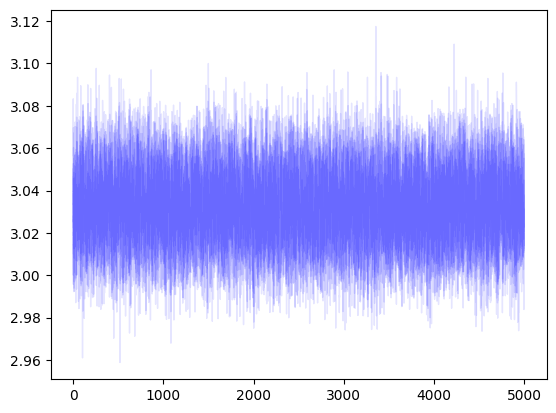

In [32]:
p = np.reshape( mcmc_results_big['q'], (Nchain, Nsample, Nr))

for i in range(8):
    plt.plot( p[i, :,21],  color='b', lw=1, alpha=0.1 ) 
        
print(R[21])
#plt.yscale('log')


#plt.ylim(-0.2, 0.2)
#plt.xlim(20, 80)

25.302188187762273


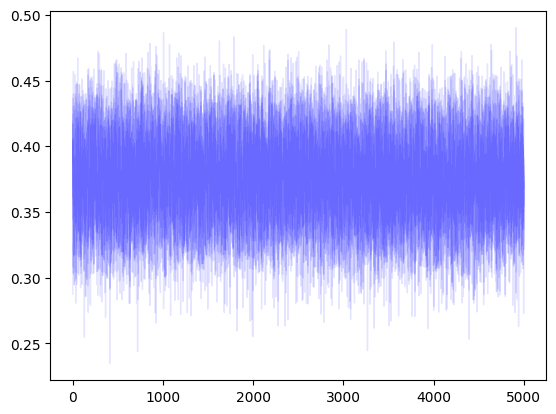

In [33]:
p = np.reshape( mcmc_results_big['Sigma_d'], (Nchain, Nsample, Nr))

for i in range(8):
    plt.plot( p[i, :,21],  color='b', lw=1, alpha=0.1 ) 
        
print(R[21])
#plt.yscale('log')


#plt.ylim(-0.2, 0.2)
#plt.xlim(20, 80)

In [36]:
mcmc_sample

{'alpha_ff': Array([-0.58120754, -0.50798929, -0.55804608, ..., -0.31474287,
        -0.3284811 , -0.31165764], dtype=float64),
 'beta_ff': Array([-2.46421071, -2.38744584, -2.25625213, ..., -2.68371136,
        -2.49379869, -1.55785219], dtype=float64),
 'g_Sigma_d': Array([[ 0.44787571,  0.40918345,  0.29318259, ..., -0.94775153,
         -0.7346571 , -0.46332049],
        [ 0.52071531,  0.40703125,  0.29475105, ..., -1.02535462,
         -0.77637849, -0.50287759],
        [ 0.52523073,  0.40359322,  0.28877318, ..., -1.02136087,
         -0.73893269, -0.31891534],
        ...,
        [ 0.70046977,  0.70697215,  0.63305082, ..., -0.81056996,
         -0.7846282 , -0.80788977],
        [ 0.67543586,  0.73007913,  0.65435702, ..., -0.87472632,
         -0.86397969, -0.84969965],
        [ 0.71948556,  0.65371662,  0.58071763, ..., -1.06584808,
         -0.9423188 , -0.66034769]], dtype=float64),
 'g_T': Array([[ 0.53938595,  0.34085709,  0.24404251, ..., -1.07739194,
         -0.94690

Text(0.5, 0, 'r (au)')

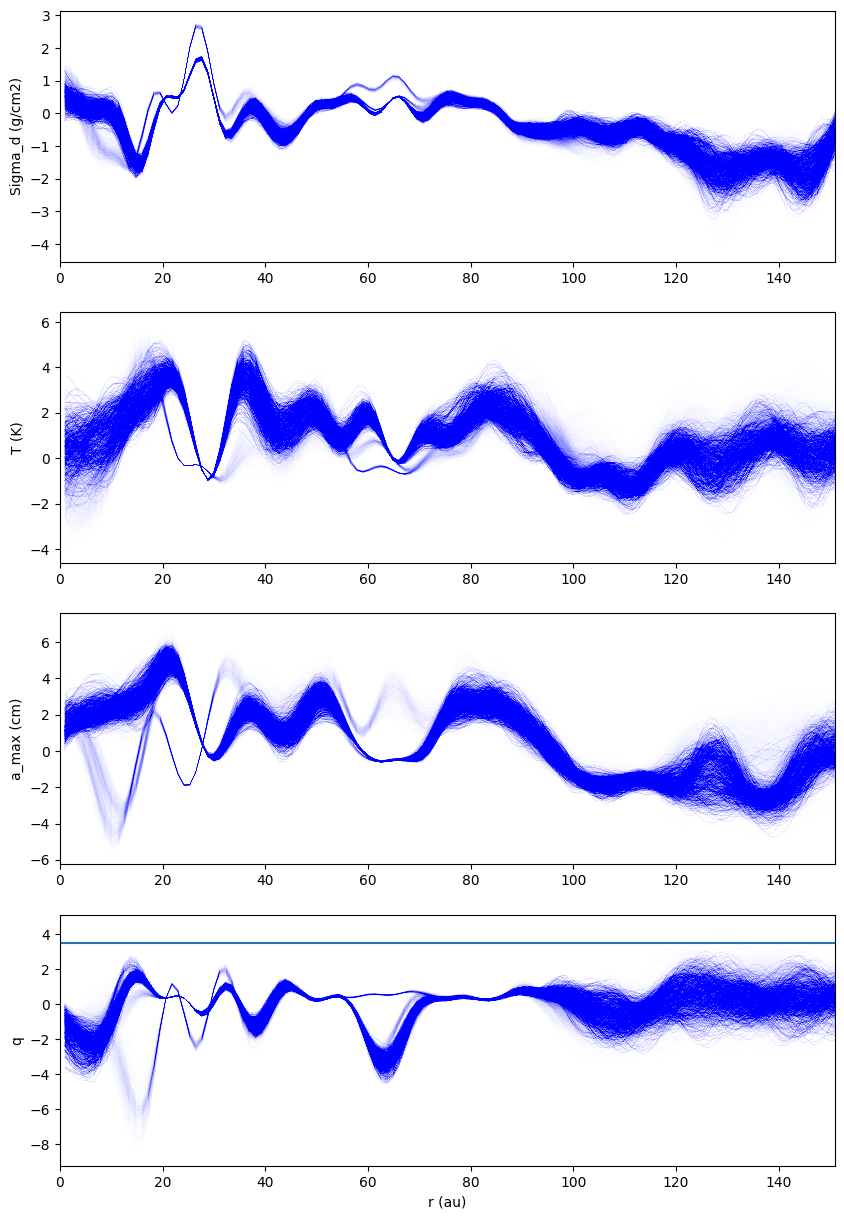

In [39]:
#plt.plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['Sigma_d'])


Nchain = 8
nstart = 0
nend = Nsample 
nskip = 10


alpha = 0.02

Rmax = np.max(diskmodel.r_GP*D)
Nr = len(diskmodel.r_GP)

fig, axes = plt.subplots(4,1, figsize=(10, 15))



p = np.reshape( mcmc_sample['g_Sigma_d'], (Nchain, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[0].plot( diskmodel.r_GP*D, _p, alpha=alpha, lw=0.1, color='b' ) 


axes[0].set_xlim(0, Rmax )

p = np.reshape( mcmc_sample['g_T'], (Nchain, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[1].plot( diskmodel.r_GP*D, _p, alpha=alpha, lw=0.1, color='b' ) 

    
Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/5)
Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*5)
Tmid = 10**jnp.log10(77*(R/10)**(-0.5))


axes[1].set_xlim(0, Rmax )

p = np.reshape( mcmc_sample['g_a_max'], (Nchain, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[2].plot( diskmodel.r_GP*D, _p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[2].set_xlim(0,  Rmax )


p = np.reshape( mcmc_sample['g_q'], (Nchain, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[3].plot( diskmodel.r_GP*D, _p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[3].plot( [0, Rmax], [3.5, 3.5] )

#axes[3].set_yscale('log')
axes[3].set_xlim(0, Rmax )


axes[0].set_ylabel('Sigma_d (g/cm2)')
axes[1].set_ylabel('T (K)')
axes[2].set_ylabel('a_max (cm)')
axes[3].set_ylabel('q')

axes[3].set_xlabel('r (au)')





40.424676989212124


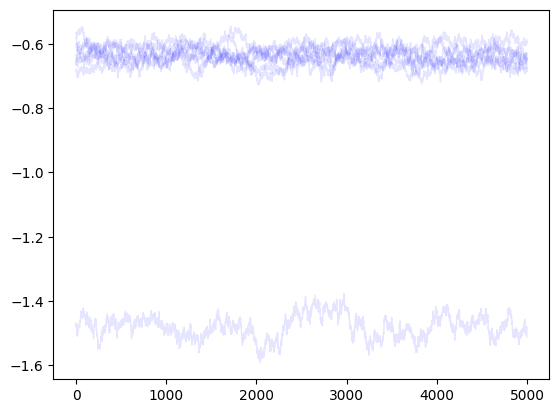

40.424676989212124


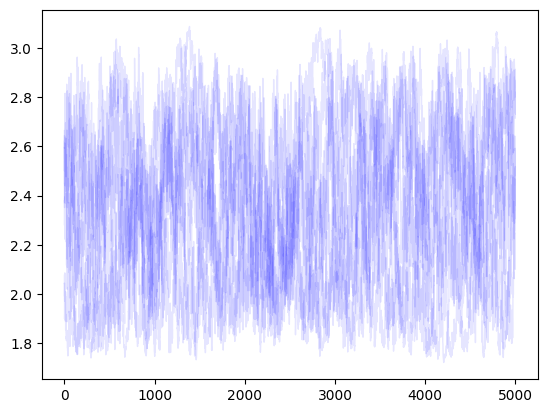

In [33]:
p = np.reshape( mcmc_results_big['T'], (Nchain, Nsample, Nr))

for i in range(8):
    plt.plot( p[i, :, 0],  color='b', lw=1, alpha=0.1 ) 
        
print(R[34])
#plt.yscale('log')


#plt.ylim(0.1, 1)
#plt.xlim(20, 80)

In [108]:
medians_bigs = {}

medians_bigs_g = {}

for i in range(8):

    rng_key= jax.random.PRNGKey(i*10+50000)
    medians_bigs_g[i], _loss = diskmodel.run_MAP( rng_key, num_iterations = 10000, num_particles = 1, adam_lr = 0.1 )
    medians_bigs[i] = diskmodel.delta_medians


100%|█| 10000/10000 [00:04<00:00, 2050.88it/s, init loss: 295047695645.4118, avg
100%|█| 10000/10000 [00:04<00:00, 2282.95it/s, init loss: 8140154164.4750, avg. 
100%|█| 10000/10000 [00:04<00:00, 2338.76it/s, init loss: 2379886550.8349, avg. 
100%|█| 10000/10000 [00:04<00:00, 2083.93it/s, init loss: 2848476104.8086, avg. 
100%|█| 10000/10000 [00:04<00:00, 2189.57it/s, init loss: 26357275559.8867, avg.
100%|█| 10000/10000 [00:04<00:00, 2278.36it/s, init loss: 5593407356.2232, avg. 
100%|█| 10000/10000 [00:04<00:00, 2216.48it/s, init loss: 4050172772.7522, avg. 
100%|█| 10000/10000 [00:09<00:00, 1094.93it/s, init loss: 4340691984.9815, avg. 


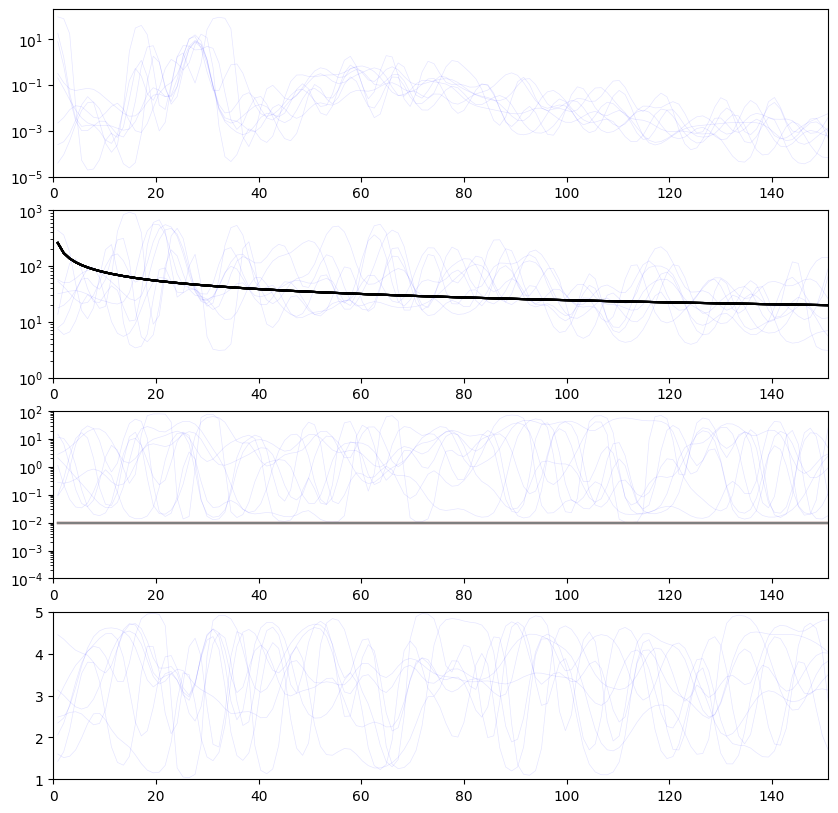

In [109]:

fig, axes = plt.subplots(4,1, figsize=(10, 10))

lw = 0.5


Rmax = np.max(diskmodel.r_GP*D)



for i in range(8):
    axes[0].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['Sigma_d'], color='b', alpha=0.1, lw=lw)


    axes[0].set_yscale('log')
    axes[0].set_xlim(0, Rmax)
    axes[0].set_ylim( 1e-5, 200)



    axes[1].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['T'], color='b', alpha=0.1, lw=lw)



    Tmid = 10**jnp.log10(77*(R/10)**(-0.5))
    #Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*10)


    axes[1].plot( R, Tmid, color='k' )

    axes[1].set_yscale('log')
    axes[1].set_xlim(0, Rmax)
    axes[1].set_ylim( 1, 1e3 )


    axes[2].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['a_max'], color='b', alpha=0.1, lw=lw)


    axes[2].plot( diskmodel.r_GP*D, diskmodel.r_GP*D*0 + 10**(-2) )
    axes[2].set_yscale('log')
    axes[2].set_xlim(0, Rmax)
    axes[2].set_ylim( 1e-4, 1e2 )


    axes[3].plot(diskmodel.r_GP*D, medians_bigs[i]['q'], color='b', alpha=0.1, lw=lw)


    axes[3].set_xlim(0, Rmax)
    axes[3].set_ylim( 1, 5 )

In [110]:
medians_map = {}

for key in medians_bigs_g[0]:
    print(key)
    
    buf = []
    
    for i in range(8):
        
        #print(i, np.shape(medians_bigs_g[i][key]))
        
        buf.append(medians_bigs_g[i][key])
        
    medians_map[key] = np.array(buf)


g_Sigma_d
g_T
g_q
g_a_max
log10F0
alpha_ff
beta_ff
g_f_scale_data_id_0
g_f_scale_data_id_1
g_f_scale_data_id_2


IndexError: index 4 is out of bounds for axis 0 with size 4

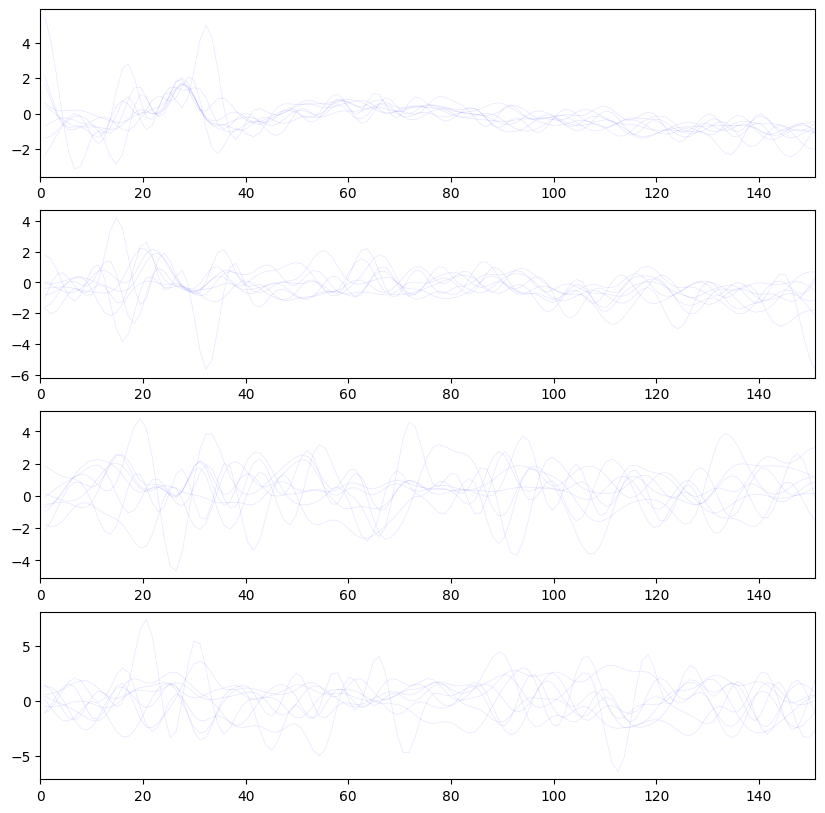

In [111]:

fig, axes = plt.subplots(4,1, figsize=(10, 10))

lw = 0.5


Rmax = np.max(diskmodel.r_GP*D)


for ikey, key in enumerate(medians_bigs_g[0]):
    for i in range(8):
        axes[ikey].plot(diskmodel.r_GP*D, medians_bigs_g[i][key], color='b', alpha=0.1, lw=lw)
    
    
       
        axes[ikey].set_xlim(0, Rmax)
    
    
    

In [82]:
rng_key = jax.random.PRNGKey(1)

mcmc_results_big = diskmodel.run_MCMC( rng_key, steps = 200,
                                   step_size = 0.01, num_chains = 8,
                                   medians = medians_map, max_tree_depth=10, 
                                      init_strategy='median' )


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha_ff     -0.81      0.63     -0.66     -1.80      0.02      5.58      2.09
              beta_ff     -1.01      1.86     -0.08     -3.74      1.07      4.52      3.08
         g_Sigma_d[0]      1.45      0.96      1.57     -0.36      2.92      4.46      3.37
         g_Sigma_d[1]      1.30      1.01      1.39     -0.27      3.22      4.20      5.13
         g_Sigma_d[2]      0.98      1.10      0.98     -1.02      2.68      4.10      7.42
         g_Sigma_d[3]      0.53      1.15      0.44     -1.69      1.99      4.09      8.63
         g_Sigma_d[4]      0.04      1.09      0.06     -2.02      1.51      4.10      8.42
         g_Sigma_d[5]     -0.37      0.91     -0.42     -1.96      1.02      4.13      7.46
         g_Sigma_d[6]     -0.64      0.63     -0.79     -1.52      0.47      4.19      5.77
         g_Sigma_d[7]     -0.80      0.39     -0.80     -1.42     -0.22      4.

Text(0.5, 0, 'r (au)')

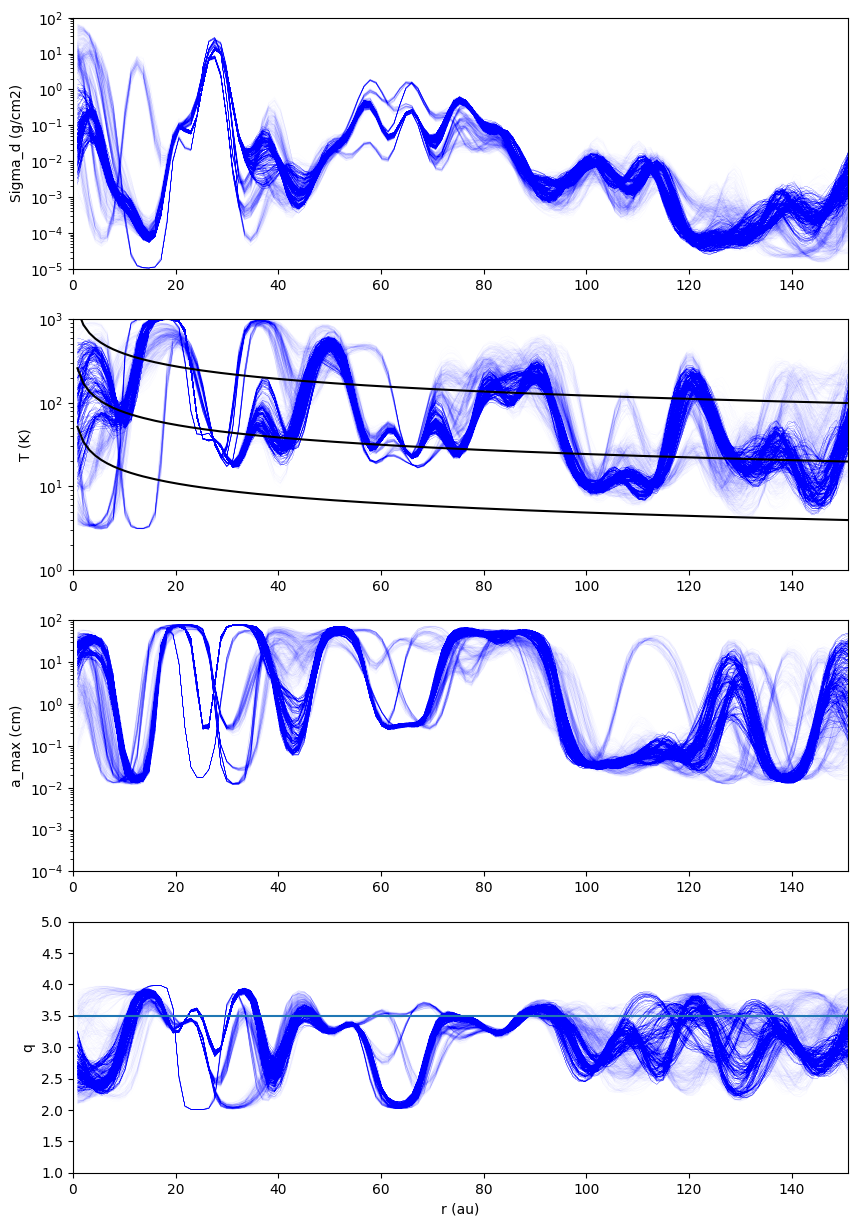

In [83]:
#plt.plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['Sigma_d'])


Nsample = 200
Nchain = 8
nstart = 0
nend = 200
nskip = 1


alpha = 0.05

Rmax = np.max(diskmodel.r_GP*D)
Nr = len(diskmodel.r_GP)

fig, axes = plt.subplots(4,1, figsize=(10, 15))



p = np.reshape( mcmc_results_big['Sigma_d'], (Nchain, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[0].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 


axes[0].set_yscale('log')
axes[0].set_xlim(0, Rmax )
axes[0].set_ylim( 1e-5, 100 )

p = np.reshape( mcmc_results_big['T'], (Nchain, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[1].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 

    
Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/5)
Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*5)
Tmid = 10**jnp.log10(77*(R/10)**(-0.5))


axes[1].plot( R, Tmin, color='k' )
axes[1].plot( R, Tmid, color='k' )
axes[1].plot( R, Tmax, color='k' )
axes[1].set_yscale('log')
axes[1].set_xlim(0, Rmax )
axes[1].set_ylim( 1, 1e3 )

p = np.reshape( mcmc_results_big['a_max'], (Nchain, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[2].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[2].set_yscale('log')
axes[2].set_xlim(0,  Rmax )
axes[2].set_ylim( 1e-4, 1e2 )


p = np.reshape( mcmc_results_big['q'], (Nchain, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[3].plot( diskmodel.r_GP*D, _p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[3].plot( [0, Rmax], [3.5, 3.5] )

#axes[3].set_yscale('log')
axes[3].set_xlim(0, Rmax )
axes[3].set_ylim( 1, 5 )


axes[0].set_ylabel('Sigma_d (g/cm2)')
axes[1].set_ylabel('T (K)')
axes[2].set_ylabel('a_max (cm)')
axes[3].set_ylabel('q')

axes[3].set_xlabel('r (au)')





24.13893296170819


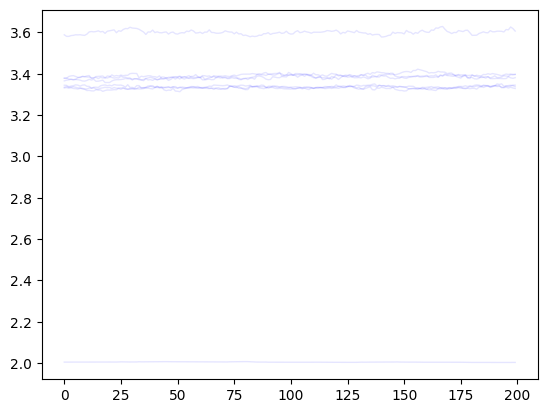

In [84]:
p = np.reshape( mcmc_results_big['q'], (Nchain, Nsample, Nr))

for i in range(8):
    plt.plot( p[i, :, 20],  color='b', lw=1, alpha=0.1 ) 
        
print(R[20])
#plt.yscale('log')


#plt.ylim(0.1, 1)
#plt.xlim(20, 80)

In [34]:
samples = diskmodel.mcmc_results.get_samples()

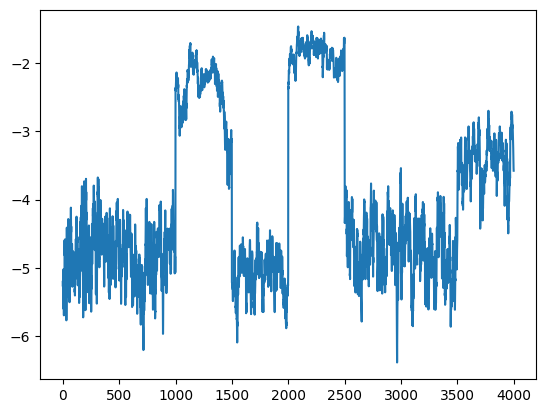

In [35]:
plt.plot(samples['g_f_scale_data_id_0'])

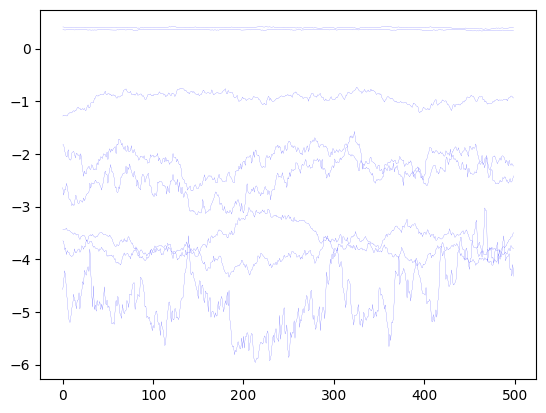

In [36]:
p = np.reshape( samples['g_q'], (Nchain, Nsample, Nr))

for i in range(8):
    plt.plot( p[i, :, 20],  color='b', lw=0.1, alpha=1 ) 
        



#plt.ylim(-3, -2.9)
#plt.xlim(20, 80)

In [72]:
slack_notify()

In [73]:
import pickle

results = { 'mcmc_results' : mcmc_results_big, 'r' : diskmodel.r_GP*D }

with open('mcmc_results_20260108.pkl', 'wb') as f:
    pickle.dump(results, f)

Text(0.5, 0, 'r (au)')

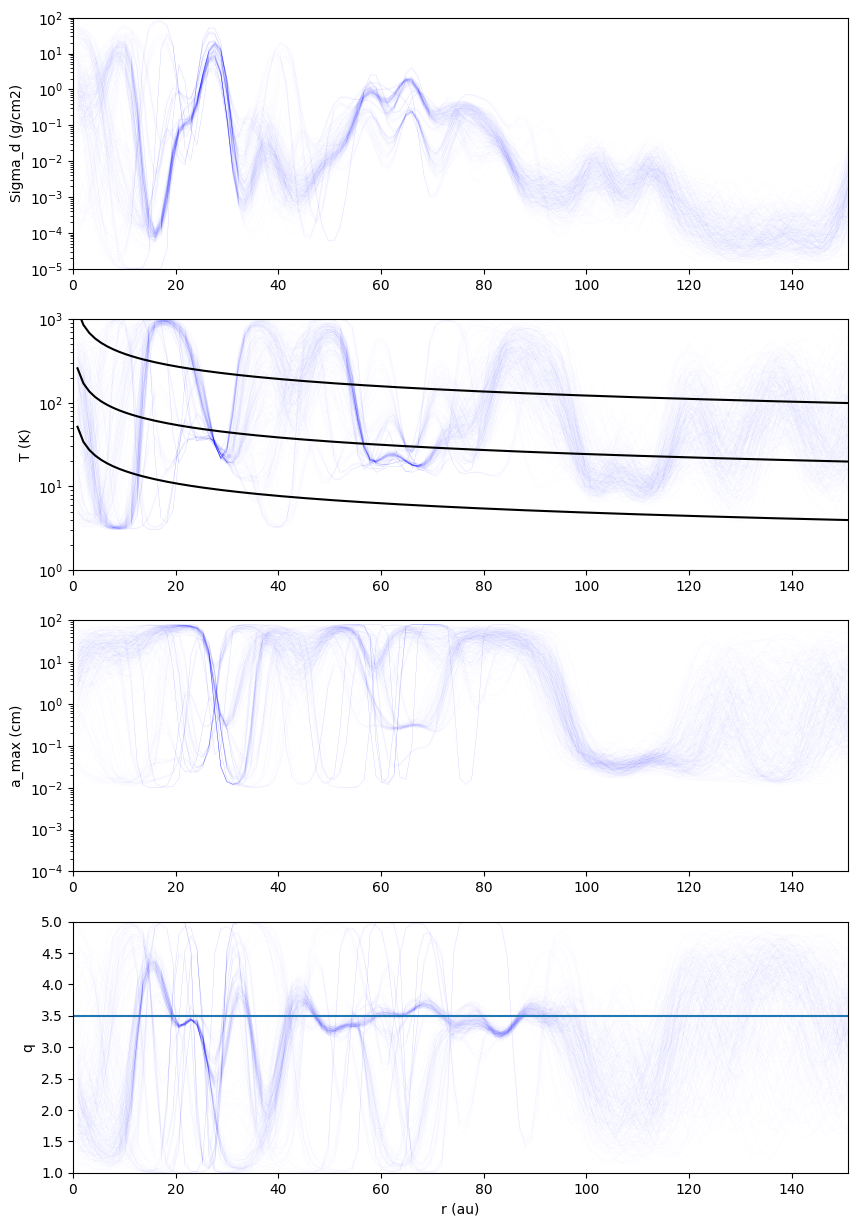

In [77]:
#plt.plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['Sigma_d'])


Nsample = 50000

nstart = 40000
nend = 50000
nskip = 1000


alpha = 0.05

Rmax = np.max(diskmodel.r_GP*D)
Nr = len(diskmodel.r_GP)

fig, axes = plt.subplots(4,1, figsize=(10, 15))



p = np.reshape( mcmc_results_big['Sigma_d'], (32, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[0].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 


axes[0].set_yscale('log')
axes[0].set_xlim(0, Rmax )
axes[0].set_ylim( 1e-5, 100 )

p = np.reshape( mcmc_results_big['T'], (32, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[1].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 

    
Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/5)
Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*5)
Tmid = 10**jnp.log10(77*(R/10)**(-0.5))


axes[1].plot( R, Tmin, color='k' )
axes[1].plot( R, Tmid, color='k' )
axes[1].plot( R, Tmax, color='k' )
axes[1].set_yscale('log')
axes[1].set_xlim(0, Rmax )
axes[1].set_ylim( 1, 1e3 )

p = np.reshape( mcmc_results_big['a_max'], (32, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[2].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[2].set_yscale('log')
axes[2].set_xlim(0,  Rmax )
axes[2].set_ylim( 1e-4, 1e2 )


p = np.reshape( mcmc_results_big['q'], (32, Nsample, Nr))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[3].plot( diskmodel.r_GP*D, _p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[3].plot( [0, Rmax], [3.5, 3.5] )

#axes[3].set_yscale('log')
axes[3].set_xlim(0, Rmax )
axes[3].set_ylim( 1, 5 )


axes[0].set_ylabel('Sigma_d (g/cm2)')
axes[1].set_ylabel('T (K)')
axes[2].set_ylabel('a_max (cm)')
axes[3].set_ylabel('q')

axes[3].set_xlabel('r (au)')





64.8535623016139


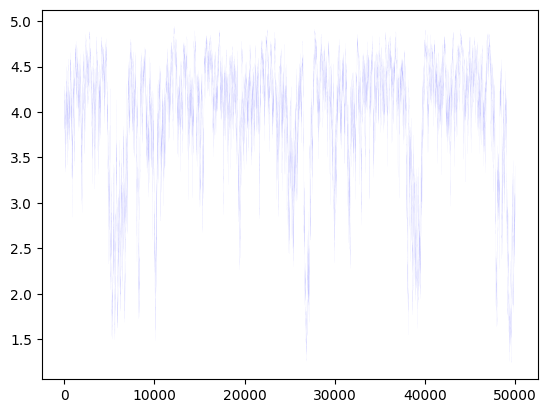

In [103]:
p = np.reshape( mcmc_results_big['q'], (32, Nsample, Nr))

for i in range(1):
    plt.plot( p[i, :, 120],  color='b', lw=0.01, alpha=1 ) 
        
print(R[55])
#plt.yscale('log')


#plt.ylim(0.1, 1)
#plt.xlim(20, 80)

In [86]:
print(R[20])

24.13893296170819


64.8535623016139


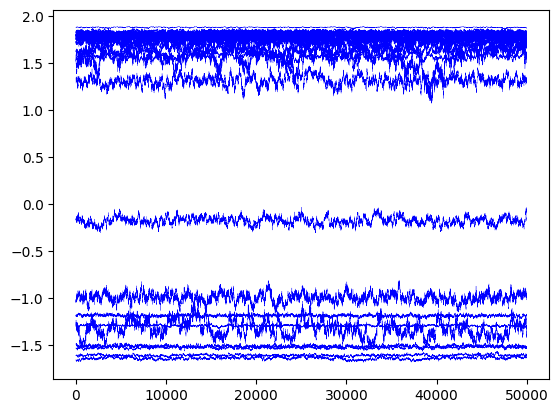

In [87]:
p = np.reshape( mcmc_results_big['a_max'], (32, Nsample, Nr))

for i in range(32):
    plt.plot( p[i, :, 20],  color='b', lw=0.2 ) 
        
print(R[55])
#plt.yscale('log')


#plt.ylim(0.1, 1)
#plt.xlim(20, 80)

In [97]:
p = np.reshape( mcmc_results_big['a_max'], (32, Nsample, Nr))
amax_std = np.std( p[:, :, 20], axis=1 )
p = np.reshape( mcmc_results_big['q'], (32, Nsample, Nr))
q_std = np.std( p[:, :, 20], axis=1 )
q_mean = np.mean( p[:, :, 20], axis=1 )

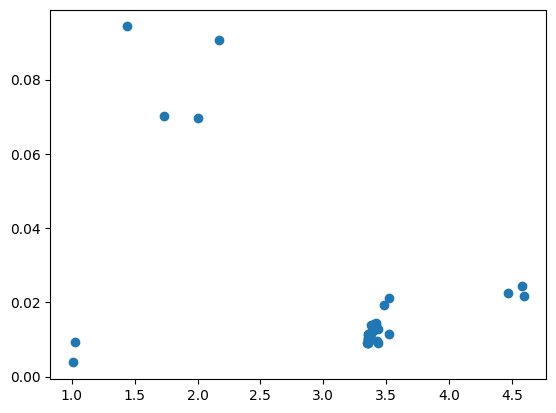

In [98]:
plt.scatter( q_mean, q_std )

64.8535623016139


(-0.1, 0.0)

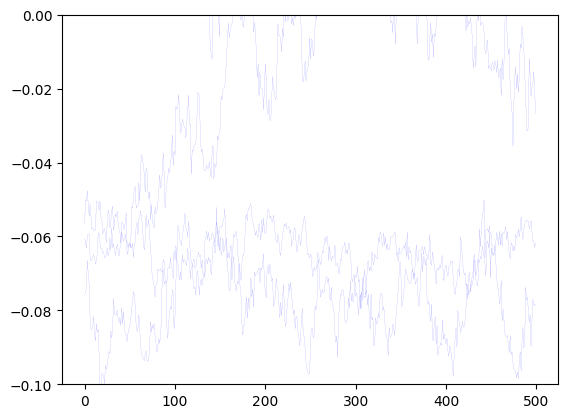

In [77]:
p = np.reshape( mcmc_results_big['a_max'], (32, Nsample, Nr))

for i in range(32):
    plt.plot( p[i, :, 55],  color='b', lw=0.1, alpha = 0.6 ) 
        
print(R[55])
#plt.yscale('log')


plt.ylim(-0.1, 0)
#plt.xlim(20, 80)

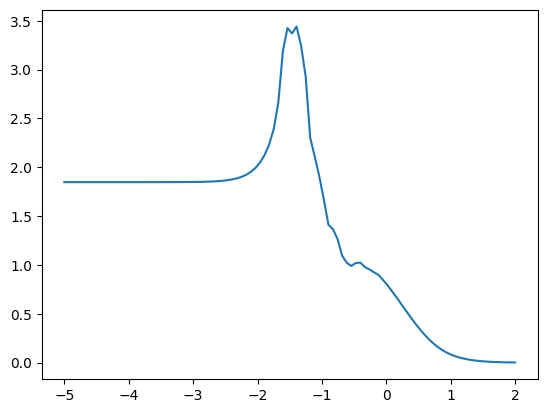

In [39]:
plt.plot( log10a, beta_25 )

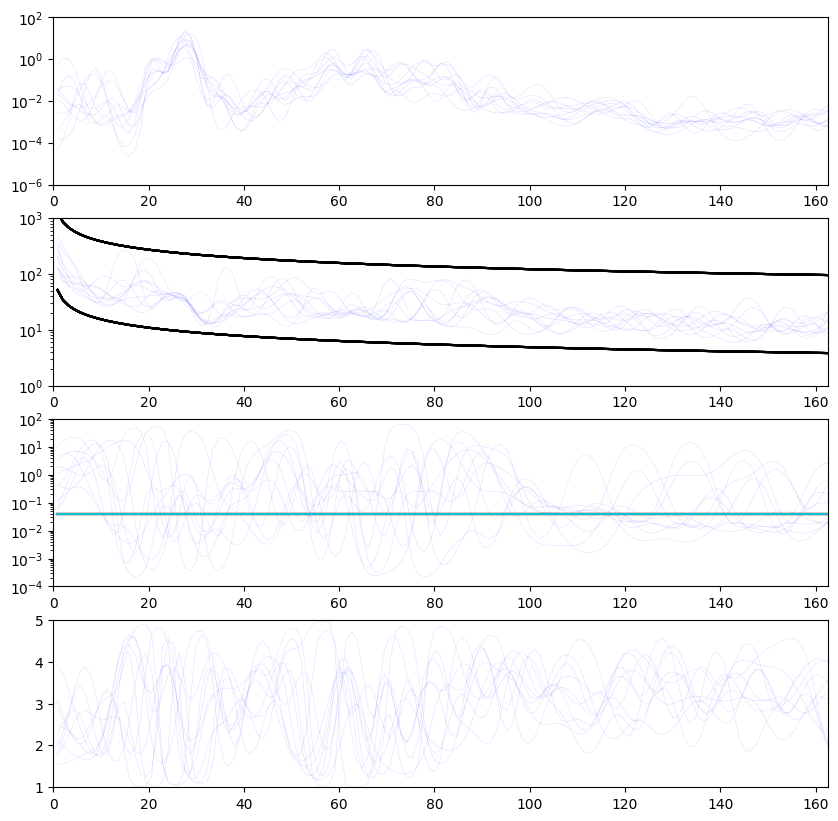

In [24]:

fig, axes = plt.subplots(4,1, figsize=(10, 10))

lw = 0.5


Rmax = np.max(diskmodel.r_GP*D)
for i in range(10):
    axes[0].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['Sigma_d'], color='b', alpha=0.1, lw=lw)


    axes[0].set_yscale('log')
    axes[0].set_xlim(0, Rmax)
    axes[0].set_ylim( 1e-6, 100)



    axes[1].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['T'], color='b', alpha=0.1, lw=lw)



    Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/5)
    Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*5)


    axes[1].plot( R, Tmin, color='k' )
    axes[1].plot( R, Tmax, color='k' )

    axes[1].set_yscale('log')
    axes[1].set_xlim(0, Rmax)
    axes[1].set_ylim( 1, 1e3 )


    axes[2].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['a_max'], color='b', alpha=0.1, lw=lw)


    axes[2].plot( diskmodel.r_GP*D, diskmodel.r_GP*D*0 + 10**(-1.39) )
    axes[2].set_yscale('log')
    axes[2].set_xlim(0, Rmax)
    axes[2].set_ylim( 1e-4, 1e2 )


    axes[3].plot(diskmodel.r_GP*D, medians_bigs[i]['q'], color='b', alpha=0.1, lw=lw)


    axes[3].set_xlim(0, Rmax)
    axes[3].set_ylim( 1, 5 )

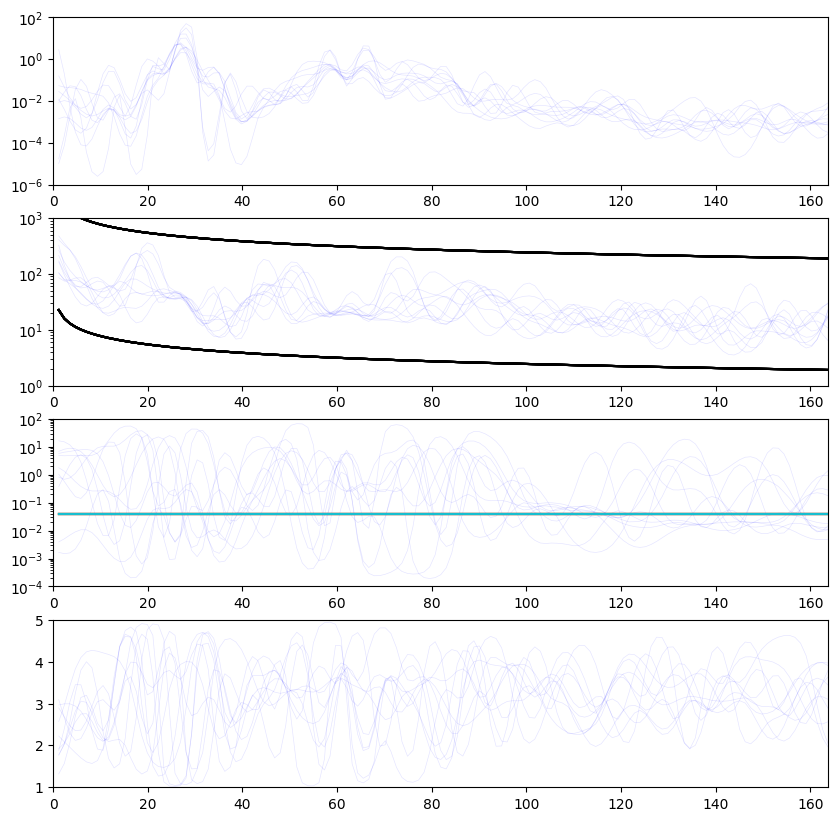

In [42]:

fig, axes = plt.subplots(4,1, figsize=(10, 10))

lw = 0.5


Rmax = np.max(diskmodel.r_GP*D)
for i in range(10):
    axes[0].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['Sigma_d'], color='b', alpha=0.1, lw=lw)


    axes[0].set_yscale('log')
    axes[0].set_xlim(0, Rmax)
    axes[0].set_ylim( 1e-6, 100)



    axes[1].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['T'], color='b', alpha=0.1, lw=lw)



    Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/10)
    Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*10)


    axes[1].plot( R, Tmin, color='k' )
    axes[1].plot( R, Tmax, color='k' )

    axes[1].set_yscale('log')
    axes[1].set_xlim(0, Rmax)
    axes[1].set_ylim( 1, 1e3 )


    axes[2].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['a_max'], color='b', alpha=0.1, lw=lw)


    axes[2].plot( diskmodel.r_GP*D, diskmodel.r_GP*D*0 + 10**(-1.39) )
    axes[2].set_yscale('log')
    axes[2].set_xlim(0, Rmax)
    axes[2].set_ylim( 1e-4, 1e2 )


    axes[3].plot(diskmodel.r_GP*D, medians_bigs[i]['q'], color='b', alpha=0.1, lw=lw)


    axes[3].set_xlim(0, Rmax)
    axes[3].set_ylim( 1, 5 )

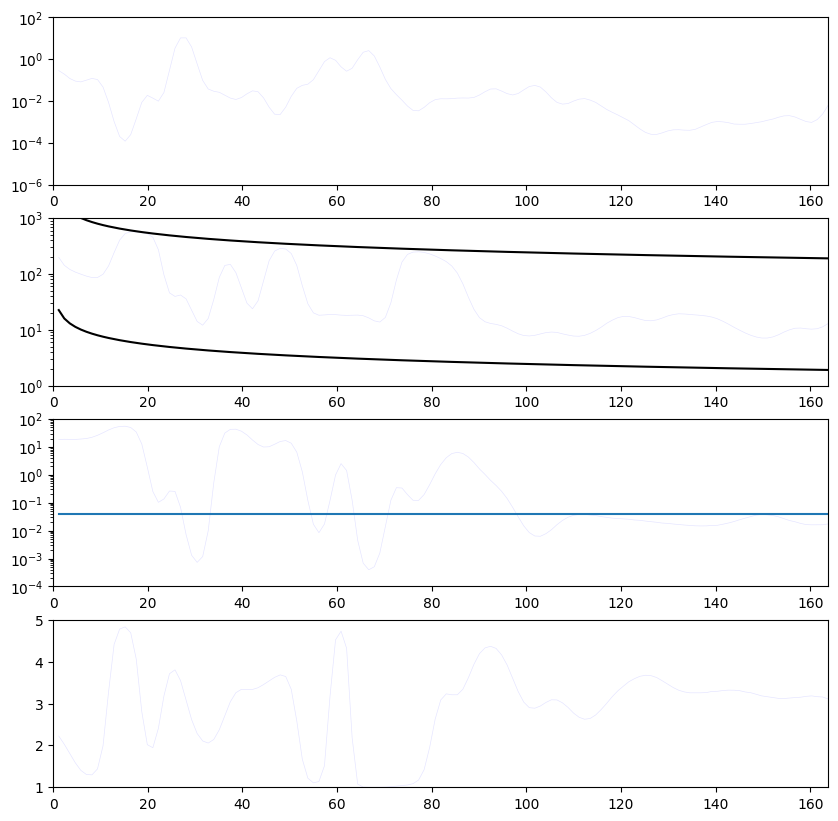

In [40]:

fig, axes = plt.subplots(4,1, figsize=(10, 10))

lw = 0.5


Rmax = np.max(diskmodel.r_GP*D)
for i in range(1):
    axes[0].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['Sigma_d'], color='b', alpha=0.1, lw=lw)


    axes[0].set_yscale('log')
    axes[0].set_xlim(0, Rmax)
    axes[0].set_ylim( 1e-6, 100)



    axes[1].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['T'], color='b', alpha=0.1, lw=lw)



    Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/10)
    Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*10)


    axes[1].plot( R, Tmin, color='k' )
    axes[1].plot( R, Tmax, color='k' )

    axes[1].set_yscale('log')
    axes[1].set_xlim(0, Rmax)
    axes[1].set_ylim( 1, 1e3 )


    axes[2].plot(diskmodel.r_GP*D, 10**medians_bigs[i]['a_max'], color='b', alpha=0.1, lw=lw)


    axes[2].plot( diskmodel.r_GP*D, diskmodel.r_GP*D*0 + 10**(-1.39) )
    axes[2].set_yscale('log')
    axes[2].set_xlim(0, Rmax)
    axes[2].set_ylim( 1e-4, 1e2 )


    axes[3].plot(diskmodel.r_GP*D, medians_bigs[i]['q'], color='b', alpha=0.1, lw=lw)


    axes[3].set_xlim(0, Rmax)
    axes[3].set_ylim( 1, 5 )

In [ ]:
rng_key = jax.random.PRNGKey(1)

mcmc_results_big = diskmodel.run_MCMC( rng_key, steps = 5000,
                                   step_size = 0.1, num_chains = 32,
                                   medians = None, max_tree_depth=10, 
                                      init_strategy='sample' )


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
#plt.plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['Sigma_d'])


Nsample = 5000

nstart = 0
nend = 5000
nskip = 1000


alpha = 0.1

Rmax = np.max(diskmodel.r_GP*D)
fig, axes = plt.subplots(4,1, figsize=(10, 15))



p = np.reshape( mcmc_results_big['Sigma_d'], (32, Nsample, 140))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[0].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 


axes[0].set_yscale('log')
axes[0].set_xlim(0, Rmax )
axes[0].set_ylim( 1e-6, 100 )

p = np.reshape( mcmc_results_big['T'], (32, Nsample, 140))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[1].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 

    
Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/5)
Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*5)
Tmid = 10**jnp.log10(77*(R/10)**(-0.5))


axes[1].plot( R, Tmin, color='k' )
axes[1].plot( R, Tmid, color='k' )
axes[1].plot( R, Tmax, color='k' )
axes[1].set_yscale('log')
axes[1].set_xlim(0, Rmax )
axes[1].set_ylim( 1, 1e3 )

p = np.reshape( mcmc_results_big['a_max'], (32, Nsample, 140))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[2].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[2].set_yscale('log')
axes[2].set_xlim(0,  Rmax )
axes[2].set_ylim( 1e-5, 1e3 )


p = np.reshape( mcmc_results_big['q'], (32, Nsample, 140))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[3].plot( diskmodel.r_GP*D, _p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[3].plot( [0, Rmax], [3.5, 3.5] )

#axes[3].set_yscale('log')
axes[3].set_xlim(0, Rmax )
axes[3].set_ylim( 1, 5 )


axes[0].set_ylabel('Sigma_d (g/cm2)')
axes[1].set_ylabel('T (K)')
axes[2].set_ylabel('a_max (cm)')
axes[3].set_ylabel('q')

axes[3].set_xlabel('r (au)')






In [ ]:
slack_notify()

In [ ]:
160/117

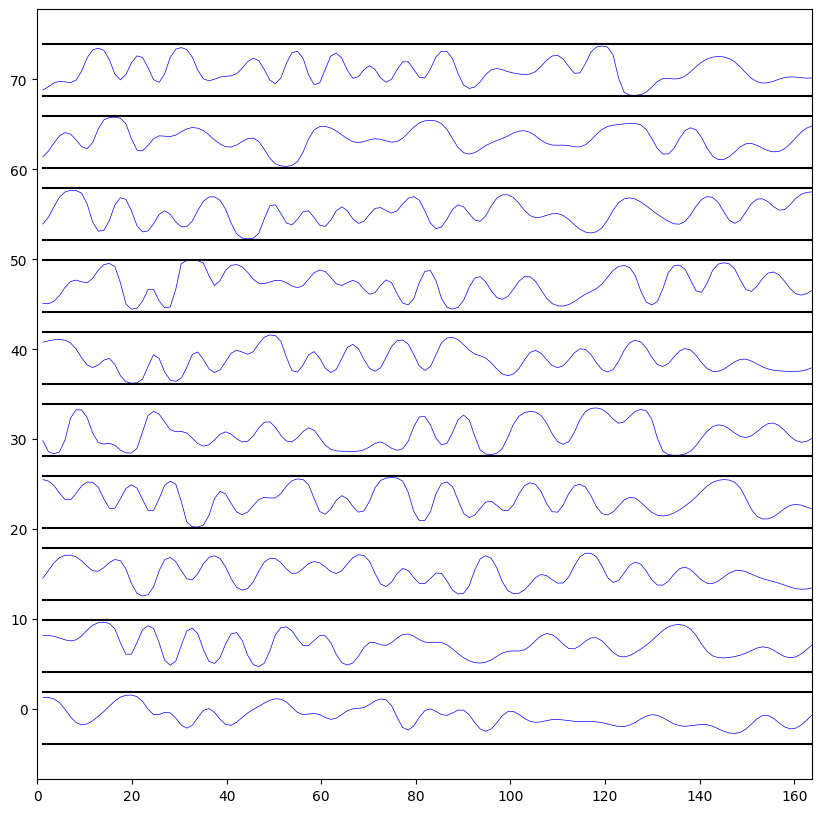

In [73]:

fig, axes = plt.subplots(1,1, figsize=(10, 10))
axes = [axes]
lw = 0.5


Rmax = np.max(diskmodel.r_GP*D)
for i in range(10):
  


    axes[0].plot(diskmodel.r_GP*D, medians_bigs[i]['a_max'] + 8*i, color='b', alpha=1, lw=lw)
    
    axes[0].plot(diskmodel.r_GP*D, diskmodel.r_GP*D*0 -3.9 + 8*i, color='k' )
    axes[0].plot(diskmodel.r_GP*D, diskmodel.r_GP*D*0 +1.9+ 8*i, color='k' )


    #axes[0].set_yscale('log')
    axes[0].set_xlim(0, Rmax)
    #axes[0].set_ylim( 1e-5, 1e2 )


   

In [ ]:

fig, axes = plt.subplots(4,1, figsize=(10, 10))

axes[0].plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['Sigma_d'])


#axes[0].set_yscale('log')
axes[0].set_xlim(0, 117*1.5)
axes[0].set_ylim( 1e-6, 1)



axes[1].plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['T'])


Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/5)
Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*5)


axes[1].plot( R, Tmin, color='k' )
axes[1].plot( R, Tmax, color='k' )

axes[1].set_yscale('log')
axes[1].set_xlim(0, 120)
axes[1].set_ylim( 1, 1e3 )


axes[2].plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['a_max'])

axes[2].set_yscale('log')
axes[2].set_xlim(0, 117*1.5)
axes[2].set_ylim( 1e-5, 1e3 )


axes[3].plot(diskmodel.r_GP*D, diskmodel.delta_medians['q'])

axes[3].set_xlim(0, 117*1.5)
axes[3].set_ylim( 0, 6 )

In [21]:
slack_notify()

Text(0.5, 0, 'r (au)')

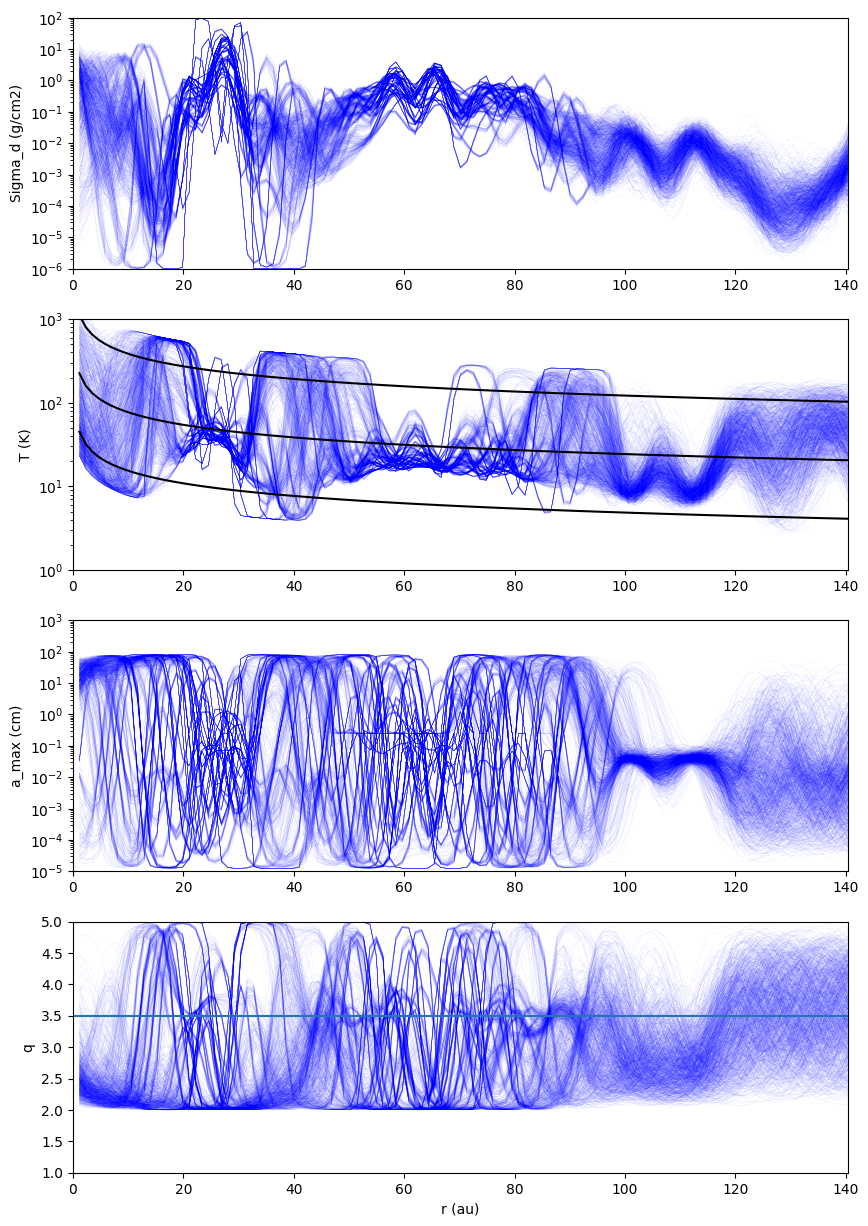

In [27]:
#plt.plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['Sigma_d'])


Nsample = 50000

nstart = 10000
nend = 50000
nskip = 1000


alpha = 0.2

Rmax = np.max(diskmodel.r_GP*D)
fig, axes = plt.subplots(4,1, figsize=(10, 15))



p = np.reshape( mcmc_results_big['Sigma_d'], (32, Nsample, 120))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[0].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 


axes[0].set_yscale('log')
axes[0].set_xlim(0, Rmax )
axes[0].set_ylim( 1e-6, 100 )

p = np.reshape( mcmc_results_big['T'], (32, Nsample, 120))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[1].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 

    
Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/5)
Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*5)
Tmid = 10**jnp.log10(77*(R/10)**(-0.5))


axes[1].plot( R, Tmin, color='k' )
axes[1].plot( R, Tmid, color='k' )
axes[1].plot( R, Tmax, color='k' )
axes[1].set_yscale('log')
axes[1].set_xlim(0, Rmax )
axes[1].set_ylim( 1, 1e3 )

p = np.reshape( mcmc_results_big['a_max'], (32, Nsample, 120))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[2].plot( diskmodel.r_GP*D, 10**_p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[2].set_yscale('log')
axes[2].set_xlim(0,  Rmax )
axes[2].set_ylim( 1e-5, 1e3 )


p = np.reshape( mcmc_results_big['q'], (32, Nsample, 120))

for i in range(32):
    for _p in p[i, nstart:nend:nskip]:
        axes[3].plot( diskmodel.r_GP*D, _p, alpha=alpha, lw=0.1, color='b' ) 

    
axes[3].plot( [0, Rmax], [3.5, 3.5] )

#axes[3].set_yscale('log')
axes[3].set_xlim(0, Rmax )
axes[3].set_ylim( 1, 5 )


axes[0].set_ylabel('Sigma_d (g/cm2)')
axes[1].set_ylabel('T (K)')
axes[2].set_ylabel('a_max (cm)')
axes[3].set_ylabel('q')

axes[3].set_xlabel('r (au)')






In [26]:
import pickle

results = { 'mcmc_results' : mcmc_results_big, 'r' : diskmodel.r_GP*D }

with open('mcmc_results_20260106.pkl', 'wb') as f:
    pickle.dump(results, f)

In [47]:
np.shape(mcmc_results_big['q'])

(3200, 120)

In [24]:
slack_notify()

(-0.005, 0.005)

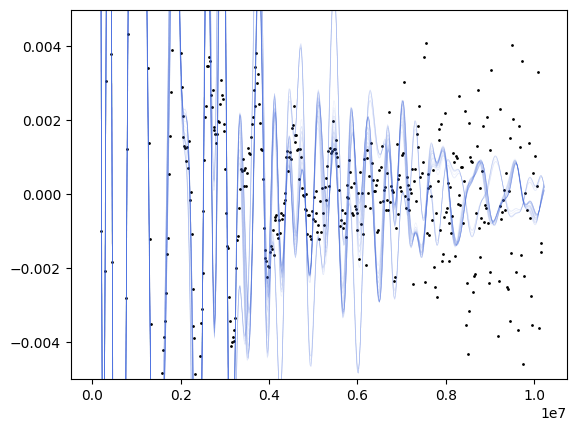

In [48]:
# データとの比較

nch = 0
dataid = 'data_id_1'

nskip = 87
R = diskmodel.r_GP*D


for nsample, _ in enumerate(mcmc_results_big['q'][::nskip, 0]):
    

    parameters = { 'Sigma_d' : mcmc_results_big['Sigma_d'][nsample],
                  'q' : mcmc_results_big['q'][nsample],
                  'a_max' :   mcmc_results_big['a_max'][nsample] ,
                   'T' : mcmc_results_big['T'][nsample] ,
                  'log10F0' : mcmc_results_big['log10F0'][nsample] ,
                  'alpha_ff' :  mcmc_results_big['alpha_ff'][nsample] ,
                  'beta_ff' :  mcmc_results_big['beta_ff'][nsample] ,

                 }
    

    V, I = diskmodel.plot_models( parameters )
    
    plt.plot( diskmodel.observations[dataid][nch].q, V[dataid][f'{dataid}_ch_{nch}'] , alpha=0.1, lw=0.4, color='royalblue')



plt.scatter( diskmodel.observations[dataid][nch].q, diskmodel.observations[dataid][nch].V, color='k', s=1)


plt.ylim(-0.005,0.005)
#plt.xlim(0, 0.4e7)

In [32]:
rng_key= jax.random.PRNGKey(10)
medians_big, _loss = diskmodel.run_MAP( rng_key, num_iterations = 10000, num_particles = 1, adam_lr = 0.1 )



100%|██████████| 10000/10000 [00:36<00:00, 277.17it/s, init loss: 6471153.3864, avg. loss [9501-10000]: -4145.6746]


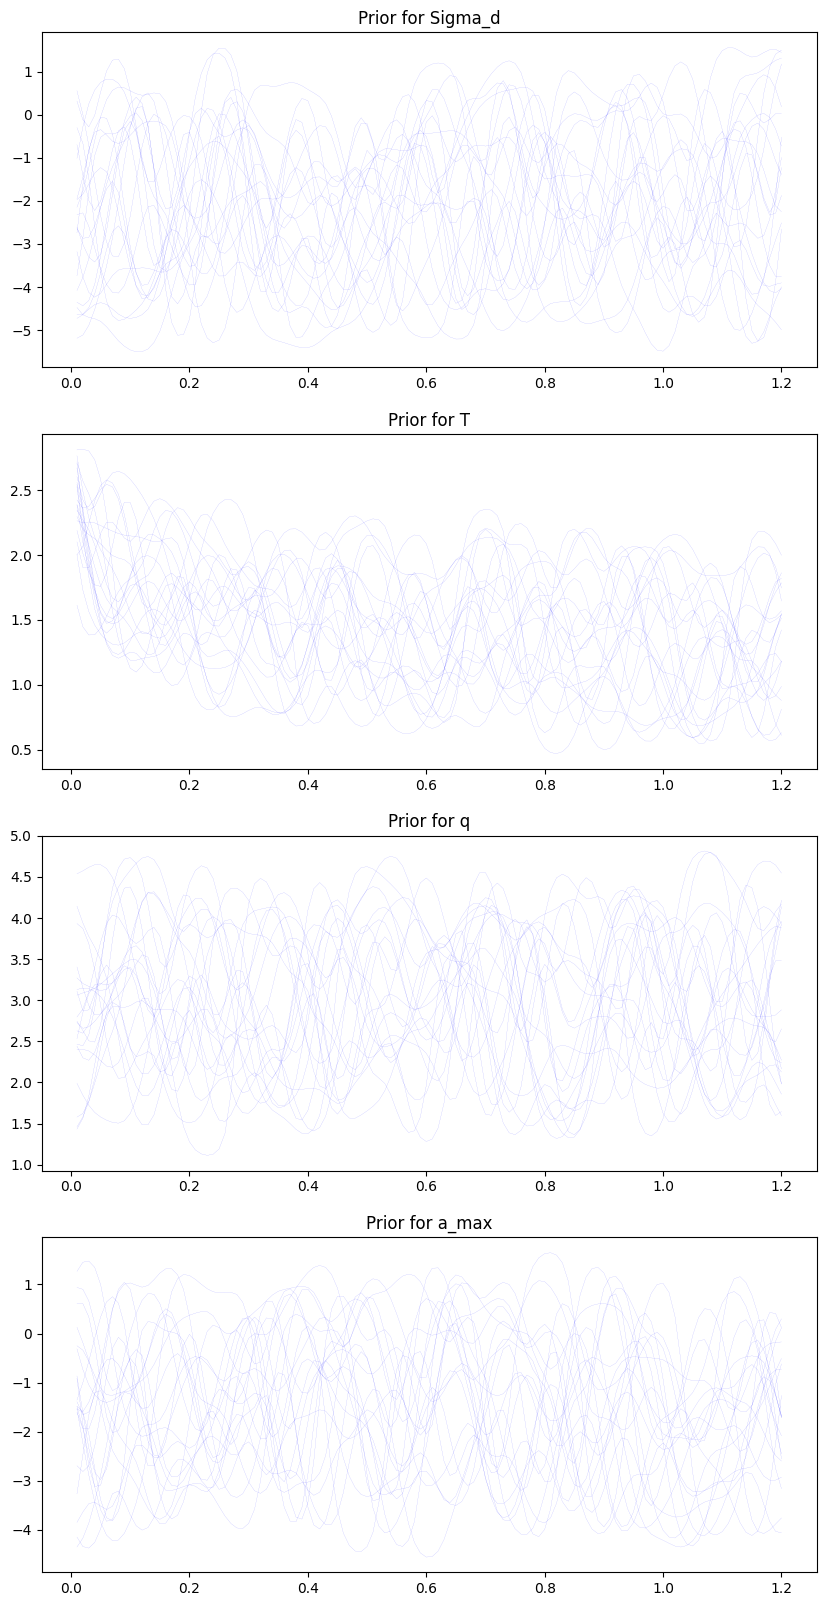

(0.0, 6.0)

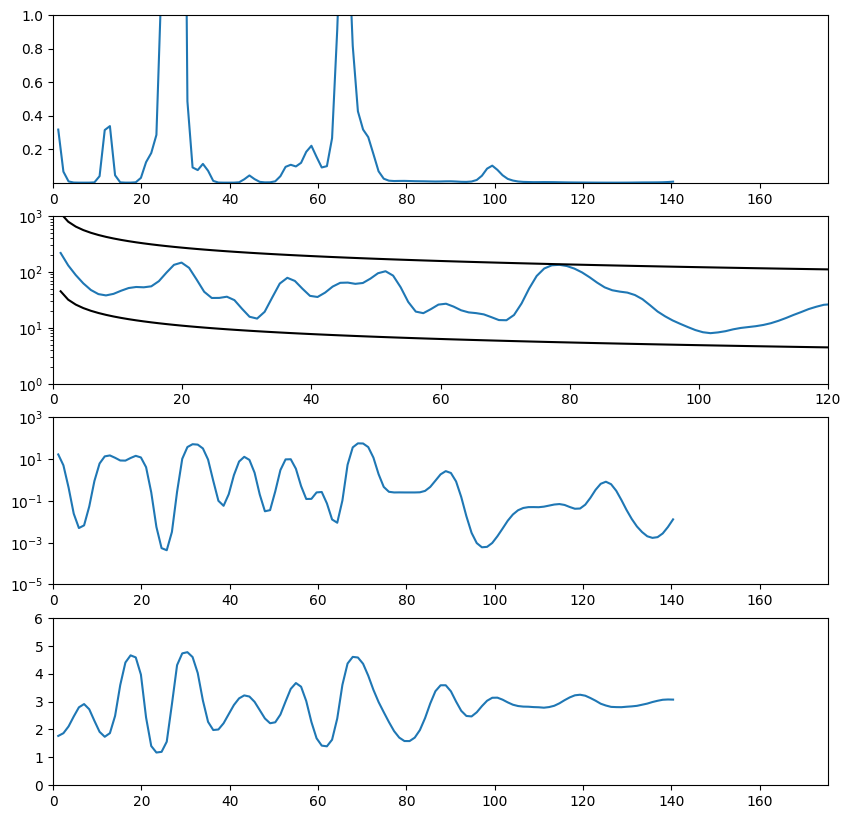

In [34]:

fig, axes = plt.subplots(4,1, figsize=(10, 10))

axes[0].plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['Sigma_d'])


#axes[0].set_yscale('log')
axes[0].set_xlim(0, 117*1.5)
axes[0].set_ylim( 1e-6, 1)



axes[1].plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['T'])


Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/5)
Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*5)


axes[1].plot( R, Tmin, color='k' )
axes[1].plot( R, Tmax, color='k' )

axes[1].set_yscale('log')
axes[1].set_xlim(0, 120)
axes[1].set_ylim( 1, 1e3 )


axes[2].plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['a_max'])

axes[2].set_yscale('log')
axes[2].set_xlim(0, 117*1.5)
axes[2].set_ylim( 1e-5, 1e3 )


axes[3].plot(diskmodel.r_GP*D, diskmodel.delta_medians['q'])

axes[3].set_xlim(0, 117*1.5)
axes[3].set_ylim( 0, 6 )

In [38]:
R = diskmodel.r_GP*D

parameters = { 'Sigma_d' : diskmodel.delta_medians['Sigma_d'] ,
              'q' : diskmodel.delta_medians['q'] ,
              'a_max' :   diskmodel.delta_medians['a_max'] ,
               'T' : diskmodel.delta_medians['T'] ,
              'log10F0' : diskmodel.delta_medians['log10F0'] ,
              'alpha_ff' :  diskmodel.delta_medians['alpha_ff'] ,
               'beta_ff' :  diskmodel.delta_medians['beta_ff'] ,
             
             }

V, I = diskmodel.plot_models( parameters )


AttributeError: 'model' object has no attribute 'delta_medians'

In [37]:
nch = 0
dataid = 'data_id_1'

#plt.scatter( loaded_data[dataid]['q'][nch], loaded_data[dataid]['V'][nch] )


for nch in range(loaded_data[dataid]['Nch']):
    plt.plot( diskmodel.observations[dataid][nch].q, V[dataid][f'{dataid}_ch_{nch}'] +nch/10 )

    
    plt.scatter( diskmodel.observations[dataid][nch].q, diskmodel.observations[dataid][nch].V+nch/10 , color='k', s=1)





NameError: name 'V' is not defined

In [38]:
nus = np.array([])
fs = np.array([])
fs_o = np.array([])

for dataid in data_ids:
    for nch in range( loaded_data[dataid]['Nch']):
        _f = V[dataid][f'{dataid}_ch_{nch}'][0]
        fs = np.append(fs, _f)
        
        _f_o = diskmodel.observations[dataid][nch].V[0]
        fs_o = np.append(fs_o, _f_o)

        _nu = diskmodel.observations[dataid][nch].nu

        nus = np.append(nus, _nu)

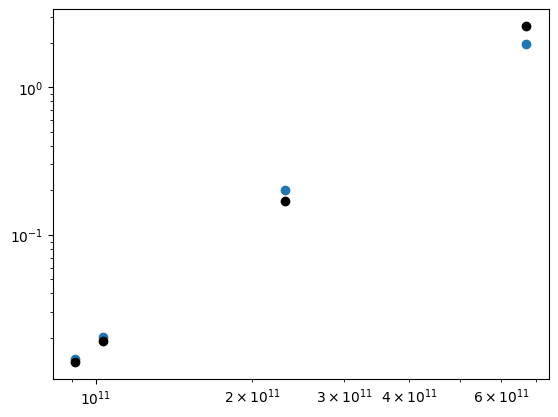

In [39]:
plt.scatter(nus, fs)
plt.scatter(nus, fs_o, color='k')
plt.xscale('log')
plt.yscale('log')

In [40]:
rng_key = jax.random.PRNGKey(1)

mcmc_results_big = diskmodel.run_MCMC( rng_key, steps = 200,
                                   step_size = 1e-3, num_chains = 32,
                                   medians = medians_big, max_tree_depth=10, init_strategy='uniform' )


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha_ff     -0.16      1.73     -0.11     -2.95      2.21     16.13     20.89
            beta_ff     -0.78      1.51     -0.94     -3.02      1.29     16.11     22.88
  f_scale_data_id_0      1.03      0.09      1.04      0.91      1.15     16.39      9.31
  f_scale_data_id_1      0.89      0.05      0.88      0.85      0.95     16.47      9.90
  f_scale_data_id_2      1.06      0.17      1.03      0.81      1.30     16.55      8.87
       g_Sigma_d[0]     -0.18      0.97     -0.21     -1.78      1.16     16.24     15.14
       g_Sigma_d[1]     -0.44      0.68     -0.51     -1.55      0.18     16.48      9.08
       g_Sigma_d[2]     -0.38      0.60     -0.50     -1.12      0.40     16.68      9.53
       g_Sigma_d[3]     -0.41      0.72     -0.49     -1.50      0.45     16.37     13.12
       g_Sigma_d[4]     -0.37      0.67     -0.58     -1.18      0.58     16.24     12.82
       g_

In [41]:
slack_notify()

Text(0.5, 0, 'r (au)')

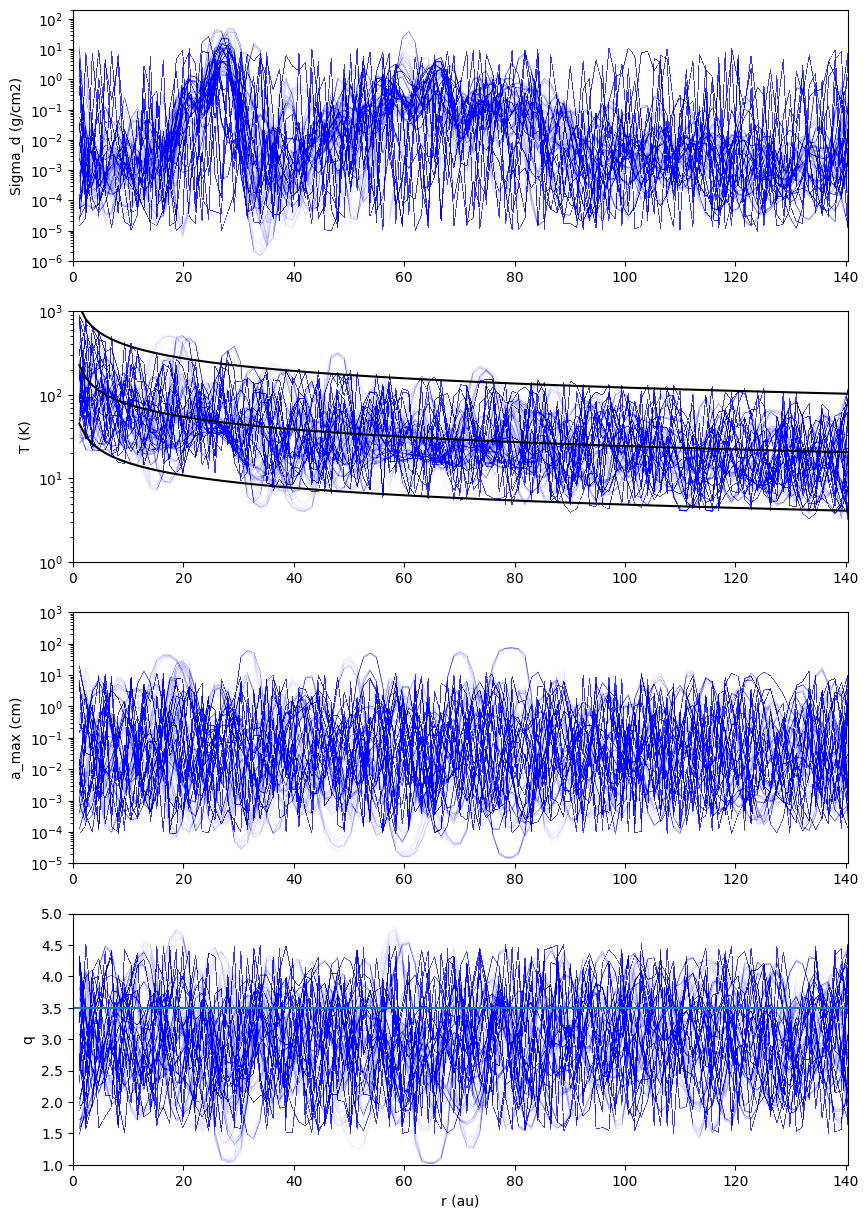

In [43]:
#plt.plot(diskmodel.r_GP*D, 10**diskmodel.delta_medians['Sigma_d'])


nskip = 1

Rmax = np.max(diskmodel.r_GP*D)
fig, axes = plt.subplots(4,1, figsize=(10, 15))

for _p in mcmc_results_big['Sigma_d'][::nskip]:
    axes[0].plot( diskmodel.r_GP*D, 10**_p, alpha=0.02, lw=0.1, color='b' ) 


axes[0].set_yscale('log')
axes[0].set_xlim(0, Rmax )
axes[0].set_ylim( 1e-6, 200 )


for _p in mcmc_results_big['T'][::nskip]:
    axes[1].plot( diskmodel.r_GP*D, 10**_p, alpha=0.02, lw=0.1, color='b' ) 

Tmin = 10**jnp.log10(77*(R/10)**(-0.5)/5)
Tmax = 10**jnp.log10(77*(R/10)**(-0.5)*5)
Tmid = 10**jnp.log10(77*(R/10)**(-0.5))


axes[1].plot( R, Tmin, color='k' )
axes[1].plot( R, Tmid, color='k' )
axes[1].plot( R, Tmax, color='k' )
axes[1].set_yscale('log')
axes[1].set_xlim(0, Rmax )
axes[1].set_ylim( 1, 1e3 )


for _p in mcmc_results_big['a_max'][::nskip]:
    axes[2].plot( diskmodel.r_GP*D, 10**_p, alpha=0.02, lw=0.1, color='b' ) 



axes[2].set_yscale('log')
axes[2].set_xlim(0,  Rmax )
axes[2].set_ylim( 1e-5, 1e3 )



for _p in mcmc_results_big['q'][::nskip]:
    axes[3].plot( diskmodel.r_GP*D, _p, alpha=0.02, lw=0.1, color='b' ) 

axes[3].plot( [0, Rmax], [3.5, 3.5] )

#axes[3].set_yscale('log')
axes[3].set_xlim(0, Rmax )
axes[3].set_ylim( 1, 5 )


axes[0].set_ylabel('Sigma_d (g/cm2)')
axes[1].set_ylabel('T (K)')
axes[2].set_ylabel('a_max (cm)')
axes[3].set_ylabel('q')

axes[3].set_xlabel('r (au)')






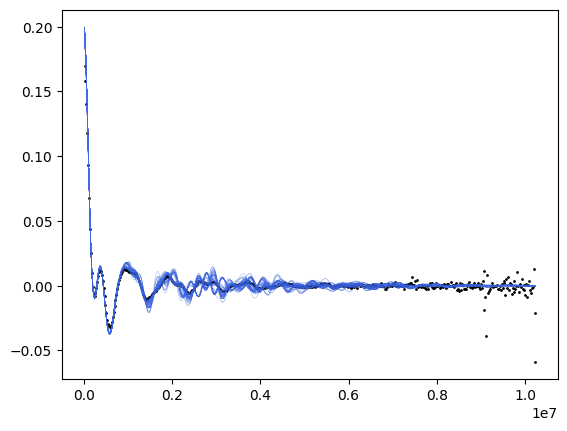

In [39]:
# データとの比較

nch = 0
dataid = 'data_id_1'

nskip = 10
R = diskmodel.r_GP*D

for nsample, _ in enumerate(mcmc_results_big['q'][::nskip, 0]):
    

    parameters = { 'Sigma_d' : mcmc_results_big['Sigma_d'][nsample],
                  'q' : mcmc_results_big['q'][nsample],
                  'a_max' :   mcmc_results_big['a_max'][nsample] ,
                   'T' : mcmc_results_big['T'][nsample] ,
                  'log10F0' : mcmc_results_big['log10F0'][nsample] ,
                  'alpha_ff' :  mcmc_results_big['alpha_ff'][nsample] ,
                  'beta_ff' :  mcmc_results_big['beta_ff'][nsample] ,

                 }
    

    V, I = diskmodel.plot_models( parameters )
    
    plt.plot( diskmodel.observations[dataid][nch].q, V[dataid][f'{dataid}_ch_{nch}'] , alpha=0.1, lw=0.4, color='royalblue')



plt.scatter( diskmodel.observations[dataid][nch].q, diskmodel.observations[dataid][nch].V, color='k', s=1)


#plt.ylim(-0.05,0.7)
#plt.xlim(0, 0.4e7)

In [ ]:
import pickle

results = { 'mcmc_results' : mcmc_results_big, 'r' : diskmodel.r_GP*D }

with open('mcmc_results_20251231.pkl', 'wb') as f:
    pickle.dump(results, f)

In [79]:
mcmc_results_big['beta_ff'][::nskip]

Array([-2.1458212 , -1.46254896, -1.9866438 , -3.50392682, -1.43079937,
       -2.74778307, -1.34434307, -0.58497731, -0.86448448, -0.81407168,
       -2.19112871, -3.6400513 , -1.05970587, -1.44540083, -2.75019824,
       -2.78079368, -0.46579652, -2.58745903, -1.67211234, -3.95043273,
       -1.41134676, -1.7903704 , -3.44771967, -1.0260339 , -1.68007548,
       -1.56704938, -0.57013629, -2.02247138, -2.76857928, -3.6169359 ,
       -1.3173456 , -1.8397944 , -2.66245089, -2.94563698, -1.16084514,
       -1.89646152, -1.53004283, -0.32498202, -3.01254214, -1.37849598,
       -0.60774514, -0.20346154, -0.66278004, -2.13932456, -0.88336066,
       -0.48769771, -0.63274586, -1.5473335 , -3.15698609, -1.33072587,
       -2.3066843 , -2.63221979, -1.48115213, -2.51855504, -0.51282707,
       -1.97404189, -0.66606309, -2.86629719, -0.88844355, -2.59286547,
       -1.32469451, -1.17041513, -0.72321611, -0.73283657, -0.93549522,
       -0.38951203, -2.04224013, -0.93805867, -2.35335734, -2.09

(-1.8, 3.8)

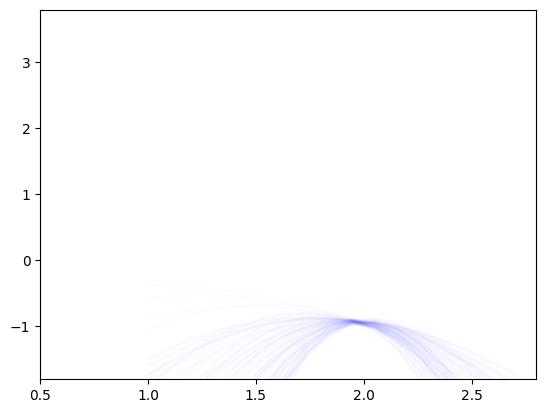

In [78]:


nu = np.logspace( 1, 3, 20 )*1e9

nu0 = 100e9

nskip = 1000
for f, a, b in zip(mcmc_results_big['log10F0'][::nskip], mcmc_results_big['alpha_ff'][::nskip], mcmc_results_big['beta_ff'][::nskip]):
    plt.plot( np.log10(nu/1e9), np.log10( 10**f * ( nu/nu0 )**(a + b * np.log(nu/nu0)) ), alpha=0.01, color='b' )
#plt.xscale('log')
#plt.yscale('log')

#plt.xlim( 80e9, 700e9 )


plt.xlim(0.5, 2.8)
plt.ylim( -1.8, 3.8 )

In [76]:
slack_notify()

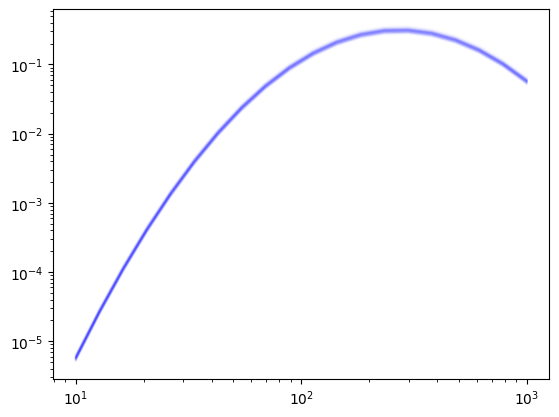

In [91]:


nu = np.logspace( 1, 3, 20 )*1e9

nu0 = 100e9

nskip = 1000
for f, a, b in zip(mcmc_results_big['log10F0'][::nskip], mcmc_results_big['alpha_ff'][::nskip], mcmc_results_big['beta_ff'][::nskip]):
    plt.plot( nu/1e9, 10**f * ( nu/nu0 )**(2 - 1 * np.log(nu/nu0)) , alpha=0.01, color='b' )
plt.xscale('log')
plt.yscale('log')

#plt.xlim( 80e9, 700e9 )


#plt.xlim(0.5, 2.8)
#plt.ylim( -1.8, 3.8 )